In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries
import pandas as pd
import numpy as np
from collections import Counter

import pydotplus
from IPython.display import Image

from sklearn import tree
import itertools
import math

from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
# original dataset
data = pd.read_csv('/content/drive/MyDrive/DM_Project_Churn_rate/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Derived dataset
data_biggroup = pd.read_csv('/content/drive/MyDrive/DM_Project_Churn_rate/data_biggroup.csv')

In [4]:
data_biggroup.head(10)

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharges,Churn
0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0
1,1,0,0,0,1,0,1,1,0,1,1,0,0,6,5,0
2,1,0,0,0,1,0,1,1,0,1,0,1,0,0,4,1
3,1,0,0,0,0,0,1,1,0,1,1,0,1,8,3,0
4,0,0,0,0,1,0,1,0,1,0,0,1,0,0,6,1
5,0,0,0,0,1,1,1,0,1,1,0,1,0,1,10,1
6,1,0,0,1,1,1,1,0,1,1,0,1,1,4,8,0
7,0,0,0,0,0,0,1,1,0,1,0,0,0,2,1,0
8,0,0,1,0,1,1,1,0,1,1,0,1,0,5,10,1
9,1,0,0,1,1,0,1,1,0,1,1,0,1,10,5,0


Skipping Contract due to inconsistent grouping.


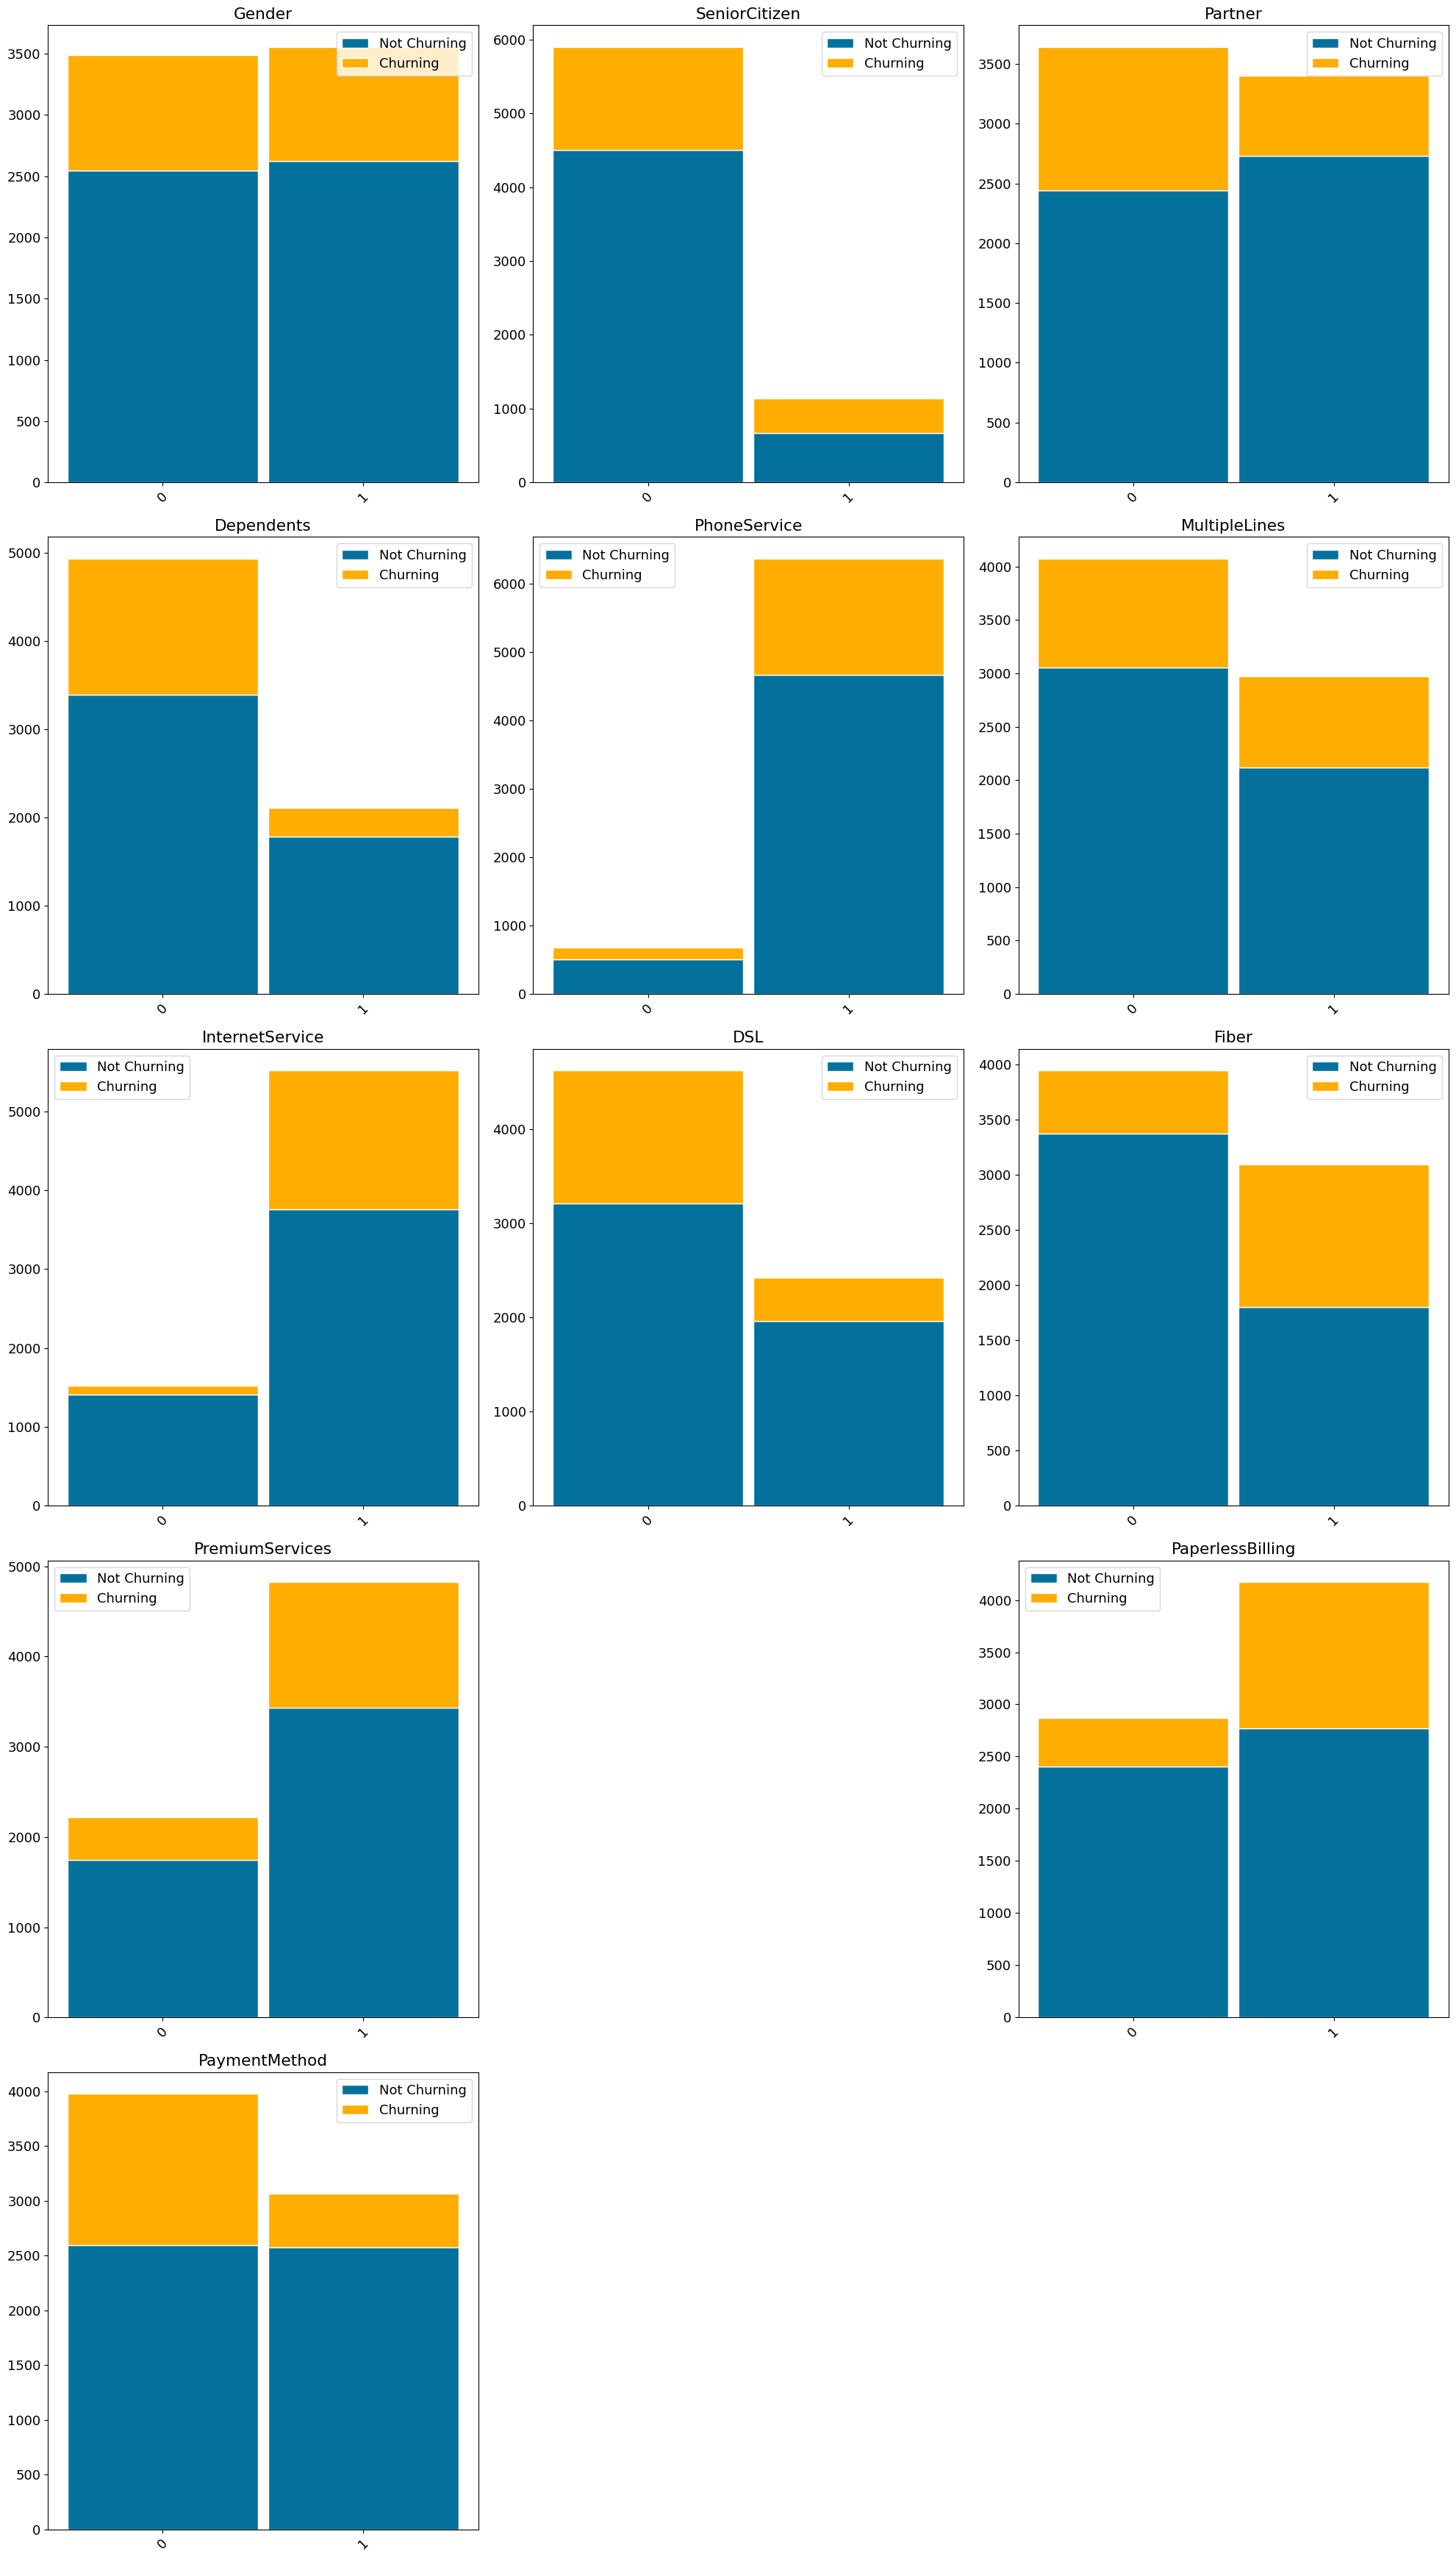

In [9]:
import matplotlib.pyplot as plt

# Define the categorical columns and labels
to_plot_cat = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
               'InternetService', 'DSL', 'Fiber', 'PremiumServices', 'PaperlessBilling', 'PaymentMethod']
label_list_custom = [['Short-Term', 'Long-Term'], ['No', 'Yes'], ['Check Methods', 'Automatic Methods']]

# Update matplotlib parameters
plt.rcParams.update({'font.size': 13})

# Initialize the figure
fig = plt.figure(figsize=(20, 35))

# Iterate over each categorical column for plotting
for index, plot in enumerate(to_plot_cat):
    # Group data by the current categorical feature and churn
    group_data = data_biggroup.groupby([plot, 'Churn']).size().unstack(fill_value=0)

    # Check for shape mismatch and handle appropriately
    if group_data.shape[0] != 2:
        print(f"Skipping {plot} due to inconsistent grouping.")
        continue

    # Prepare data for plotting
    not_churning = group_data[0].values if 0 in group_data.columns else [0] * group_data.shape[0]
    churning = group_data[1].values if 1 in group_data.columns else [0] * group_data.shape[0]

    # Plot the bar chart
    plt.subplot(5, 3, index + 1)
    plt.bar(range(len(not_churning)), not_churning, color='#03719c', edgecolor='white', width=0.95)
    plt.bar(range(len(churning)), churning, bottom=not_churning, color='#ffad01', edgecolor='white', width=0.95)

    # Set plot titles and labels
    plt.xticks(range(len(group_data.index)), group_data.index, rotation=45)
    plt.title(plot)
    plt.legend(['Not Churning', 'Churning'])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# K-Means

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
def run_kmean(X, max_k):
    sse_list = list()
    kmean_list = list()
    labels = list()
    max_k = max_k
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
        res = kmeans.fit_predict(X)
        labels.append(res)
        sse = kmeans.inertia_
        sse_list.append(sse)
        kmean_list.append(kmeans)
    return sse_list, kmean_list, labels

In [29]:
def plot_clust_distributions(data, list_to_plot):
    # plt.rcParams.update({'font.size': 13})
    to_plot_cat = list_to_plot
    fig = plt.figure(figsize=(20,35))
    for index, plot in enumerate(to_plot_cat):
        gender_dist = data[[plot, 'Churn']].groupby(plot)
        gdist_0 = list()
        gdist_1 = list()

        _r = len(data[plot].unique())
        if _r < 2:
            _fallback = data[data[plot] == 1]
            if len(_fallback) == 0:
                _fallback = data[data[plot] == 0]
                _index_attr = _fallback.iloc[0][plot]
                if _index_attr == 0:
                    _group_fallback = _fallback[[plot, 'Churn']].groupby('Churn')
                    gdist_0.append(len(_group_fallback.get_group(0)))
                    gdist_1.append(len(_group_fallback.get_group(1)))
                    gdist_0.append(0)
                    gdist_1.append(0)
                    # print(f'{plot} case omfg2')

                    plt.subplot(5, 3, index+1)
                    plt.title(plot)
                    plt.bar(_group_fallback.get_group(0).columns, gdist_0, color='#03719c', edgecolor='white', width=0.95)
                    plt.bar(_group_fallback.get_group(0).columns, gdist_1, bottom=gdist_0, color='#ffad01', edgecolor='white', width=0.95)
                    plt.xticks((0,1),('No', 'Yes'))
                    plt.legend(['Not Churning', 'Churning'])
                    continue
                else:
                    _group_fallback = _fallback[[plot, 'Churn']].groupby('Churn')
                    gdist_0.append(0)
                    gdist_1.append(0)
                    gdist_0.append(len(_group_fallback.get_group(0)))
                    gdist_1.append(len(_group_fallback.get_group(1)))
                    # print(f'{plot} case omfg2')

                    plt.subplot(5, 3, index+1)
                    plt.title(plot)
                    plt.bar(_group_fallback.get_group(0).columns, gdist_0, color='#03719c', edgecolor='white', width=0.95)
                    plt.bar(_group_fallback.get_group(0).columns, gdist_1, bottom=gdist_0, color='#ffad01', edgecolor='white', width=0.95)
                    plt.xticks((0,1),('No', 'Yes'))
                    plt.legend(['Not Churning', 'Churning'])
                    continue
            _group_fallback = _fallback[[plot, 'Churn']].groupby('Churn')
            gdist_0.append(0)
            gdist_0.append(_group_fallback.size()[0])
            gdist_1.append(0)
            gdist_1.append(_group_fallback.size()[1])

            # print(f'{plot} case 1')
            plt.subplot(5, 3, index+1)
            plt.title(plot)
            plt.bar(_group_fallback.get_group(0).columns, gdist_0, color='#03719c', edgecolor='white', width=0.95)
            plt.bar(_group_fallback.get_group(0).columns, gdist_1, bottom=gdist_0, color='#ffad01', edgecolor='white', width=0.95)
            plt.xticks((0,1),('No', 'Yes'))
            plt.legend(['Not Churning', 'Churning'])
            continue

        for i in range(len(gender_dist)):
            _temp_len = list()
            gender_df = gender_dist.get_group(i)
            churn_dist = gender_df.groupby('Churn')

            for j in range(len(churn_dist)):
                # print(f'Appending length {len(churn_dist.get_group(j))} for attr {plot}')
                _temp_len.append(len(churn_dist.get_group(j)))
                # print(f'{plot} case 2')
            gdist_0.append(_temp_len[0])
            gdist_1.append(0)
            if len(_temp_len) > 1:
                gdist_1.pop()
                gdist_1.append(_temp_len[1])
                # print(f'{plot} case 3')

        plt.subplot(5, 3, index+1)
        plt.bar(gender_dist.get_group(0).columns, gdist_0, color='#03719c', edgecolor='white', width=0.95)
        plt.bar(gender_dist.get_group(0).columns, gdist_1, bottom=gdist_0, color='#ffad01', edgecolor='white', width=0.95)
        plt.xticks((0,1),('No', 'Yes'))
        plt.title(plot)
        plt.legend(['Not Churning', 'Churning'])

In [30]:
def print_cluster_describe_cat(cluster):
       return(cluster[['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                  'MultipleLines', 'InternetService', 'DSL', 'Fiber', 'PremiumServices',
                  'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']].astype('str').describe())
def print_cluster_describe_cont(cluster):
        return(cluster[['Tenure_original', 'MonthlyCharges_original']].describe())

In [31]:
def print_single_clust_dist(cluster):
    fig = plt.figure(figsize=(20,35))
    index = 0
    for attr in cluster.columns:
        if attr not in ['Tenure', 'MonthlyCharges', 'Tenure_original', 'MonthlyCharges_original', 'kmean_label']:
            print(attr)
            print(Counter(cluster[attr]))
            c = Counter(cluster[attr])
            plt.subplot(5, 4, index+1)
            plt.bar((0,1), c.values(), color= ['#03719c', '#ffad01'])
            plt.title(attr)
            plt.xticks((0,1),('No', 'Yes'))
            index += 1

In [32]:
def plot_cont_clust(cluster, index_cluster):
    to_group_3 = ['Tenure_original', 'MonthlyCharges_original']
    fig = plt.figure(figsize=(20, 15))
    plt.suptitle('Cluster ' + str(index_cluster))
    # plt.suptitle('Tenure, MonthlyCharges and TotalCharges distributions')

    for index, plot in enumerate(to_group_3):
        temp_grouped = cluster[['MonthlyCharges_original', 'Tenure_original', 'Churn']].groupby(cluster['Churn'])

        tenure_no_churn = temp_grouped[plot].get_group(0).values.astype(float)
        tenure_churn = temp_grouped[plot].get_group(1).values.astype(float)

        plt.subplot(2, 2, index+1)
        plt.hist([tenure_no_churn, tenure_churn], 13, label=['Not Churning', 'Churning'], color=['#03719c', '#ffad01'])
        plt.legend(loc='upper right')
        plt.xlabel(plot)

In [33]:
def get_cluster_compisition(kmeans, data):
    hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
    sizes = dict(zip(bins, hist))
    for id_cluster, size in sizes.items():
        print('Cluster %d: %d (%.2f)' % (id_cluster, size, size/len(data))+'')

def evaluate_cluster(k, labels, data):
    temp_df = data.copy()
    temp_df['kmeans_label'] = labels
    _matrix = np.zeros((3,2))
    temp_df2 = pd.DataFrame(_matrix)
    for k in range(k):
        _temp = temp_df[temp_df['kmeans_label'] == k]['Churn'].values
        _r = Counter(_temp)
        print(f'Cluster {k} composition wrt to target {_r}')
        print(f'ChurningRatio: {round(_r[1]/(_r[0]+_r[1])*100, 4)}')

In [34]:
df_x_cluster = data[['tenure', 'MonthlyCharges', 'TotalCharges']]
df_x_cluster['Tenure'] = df_x_cluster['tenure']
df_x_cluster.drop(columns=['tenure'], inplace=True)

df_x_cluster[df_x_cluster['TotalCharges'] == ' '] = 0

<ipython-input-34-2a59b42ba938>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_cluster['Tenure'] = df_x_cluster['tenure']
<ipython-input-34-2a59b42ba938>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_cluster.drop(columns=['tenure'], inplace=True)
<ipython-input-34-2a59b42ba938>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [35]:
from sklearn import preprocessing

def norm_attr(data, attr):
    min_max_scaler = preprocessing.MinMaxScaler()
    _to_norm = data[attr].values
    x_scaled = min_max_scaler.fit_transform(_to_norm)
    data[attr] = x_scaled

norm_attr(df_x_cluster, ['TotalCharges'])
norm_attr(df_x_cluster, ['Tenure'])
norm_attr(df_x_cluster, ['MonthlyCharges'])

<ipython-input-35-d46d9edeb906>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[attr] = x_scaled
<ipython-input-35-d46d9edeb906>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[attr] = x_scaled
<ipython-input-35-d46d9edeb906>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [36]:
df_x_cluster = df_x_cluster[['Tenure', 'MonthlyCharges', 'TotalCharges']]

In [37]:
x_cluster = df_x_cluster.values

In [38]:
x_cluster[0]

array([0.01388889, 0.25136842, 0.00343704])

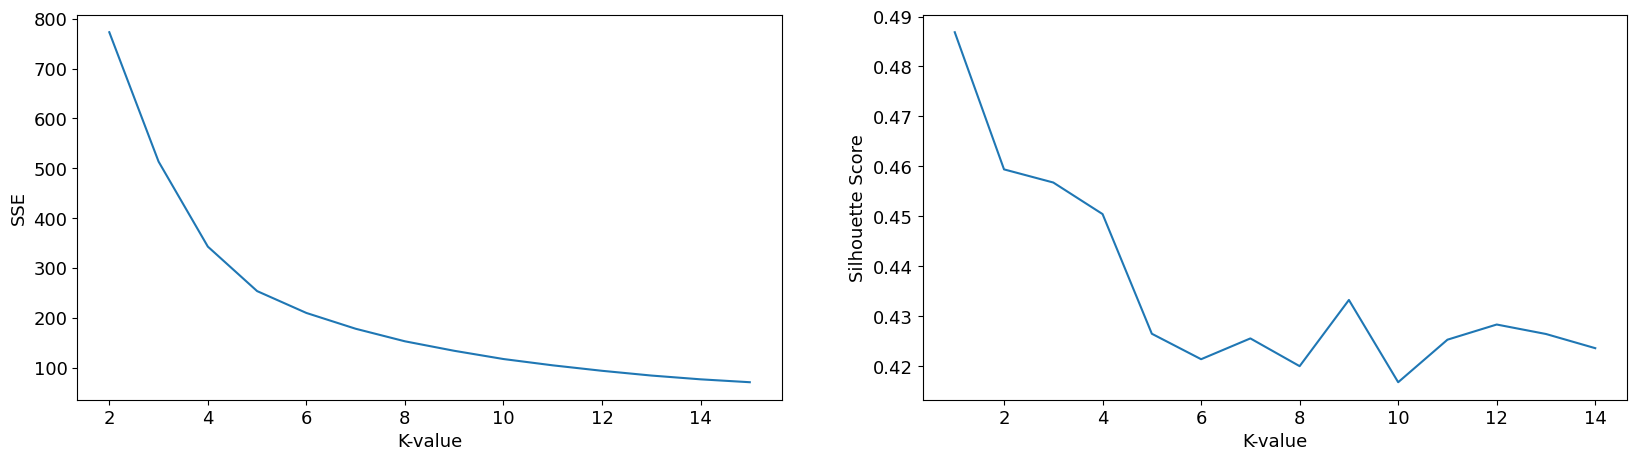

In [40]:
# Search for best k
sse_list, kmean_list, labels = run_kmean(x_cluster, 15)

silhouette_scorelist = list()
for i, km in enumerate(kmean_list):
    silhouette_scorelist.append(silhouette_score(x_cluster, km.labels_))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.xlabel('K-value')
plt.ylabel('SSE')
plt.plot(range(2, len(sse_list) + 2), sse_list)

plt.subplot(1,2,2)
plt.xlabel('K-value')
plt.ylabel('Silhouette Score')
plt.plot(range(1, len(silhouette_scorelist)+1), silhouette_scorelist)

In [41]:
silhouette_scorelist

[0.4868588491902603,
 0.4594024128713221,
 0.4567714645185311,
 0.4504553294199102,
 0.4264997160632171,
 0.4214008151249549,
 0.4255645368311843,
 0.4200099879582334,
 0.43326174661878764,
 0.41679479321088664,
 0.42530864759794945,
 0.42834550500764634,
 0.4264483293964525,
 0.4236093639800894]

In [42]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100)
labels = kmeans.fit_predict(x_cluster)
silhouette_score(x_cluster, labels)

0.4503070402769138

In [43]:
get_cluster_compisition(kmeans, x_cluster)
evaluate_cluster(5, labels, data_biggroup)

Cluster 0: 1706 (0.24)
Cluster 1: 1003 (0.14)
Cluster 2: 1498 (0.21)
Cluster 3: 1260 (0.18)
Cluster 4: 1576 (0.22)
Cluster 0 composition wrt to target Counter({1: 922, 0: 784})
ChurningRatio: 54.0445
Cluster 1 composition wrt to target Counter({0: 960, 1: 43})
ChurningRatio: 4.2871
Cluster 2 composition wrt to target Counter({0: 1310, 1: 188})
ChurningRatio: 12.5501
Cluster 3 composition wrt to target Counter({0: 919, 1: 341})
ChurningRatio: 27.0635
Cluster 4 composition wrt to target Counter({0: 1201, 1: 375})
ChurningRatio: 23.7944


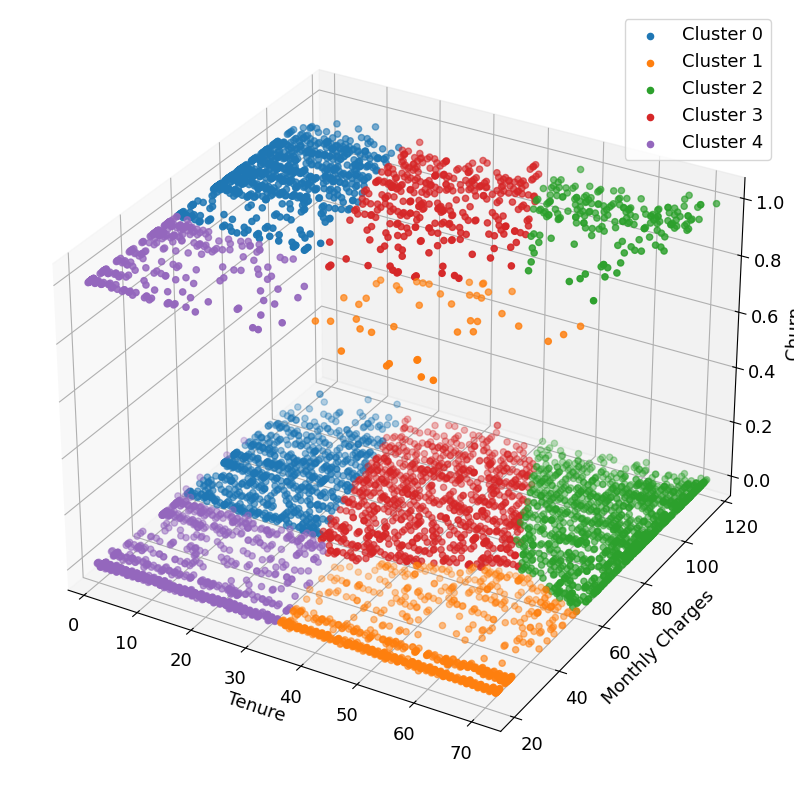

In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming data_plotclust and groups_kmeans are correctly set up
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')  # Correctly initialize the 3D Axes

# Adjust margins (optional, if needed)
ax.margins(0.02)

# Plot each cluster group
for name, group in groups_kmeans:
    cluster_name = 'Cluster ' + str(name)
    ax.scatter(group['Tenure_original'],
               group['MonthlyCharges_original'],
               group['Churn'],
               marker='o',
               s=20,
               label=cluster_name)

# Add legend and labels
ax.legend()
ax.set_xlabel('Tenure')
ax.set_ylabel('Monthly Charges')
ax.set_zlabel('Churn')

# Show the plot
plt.show()


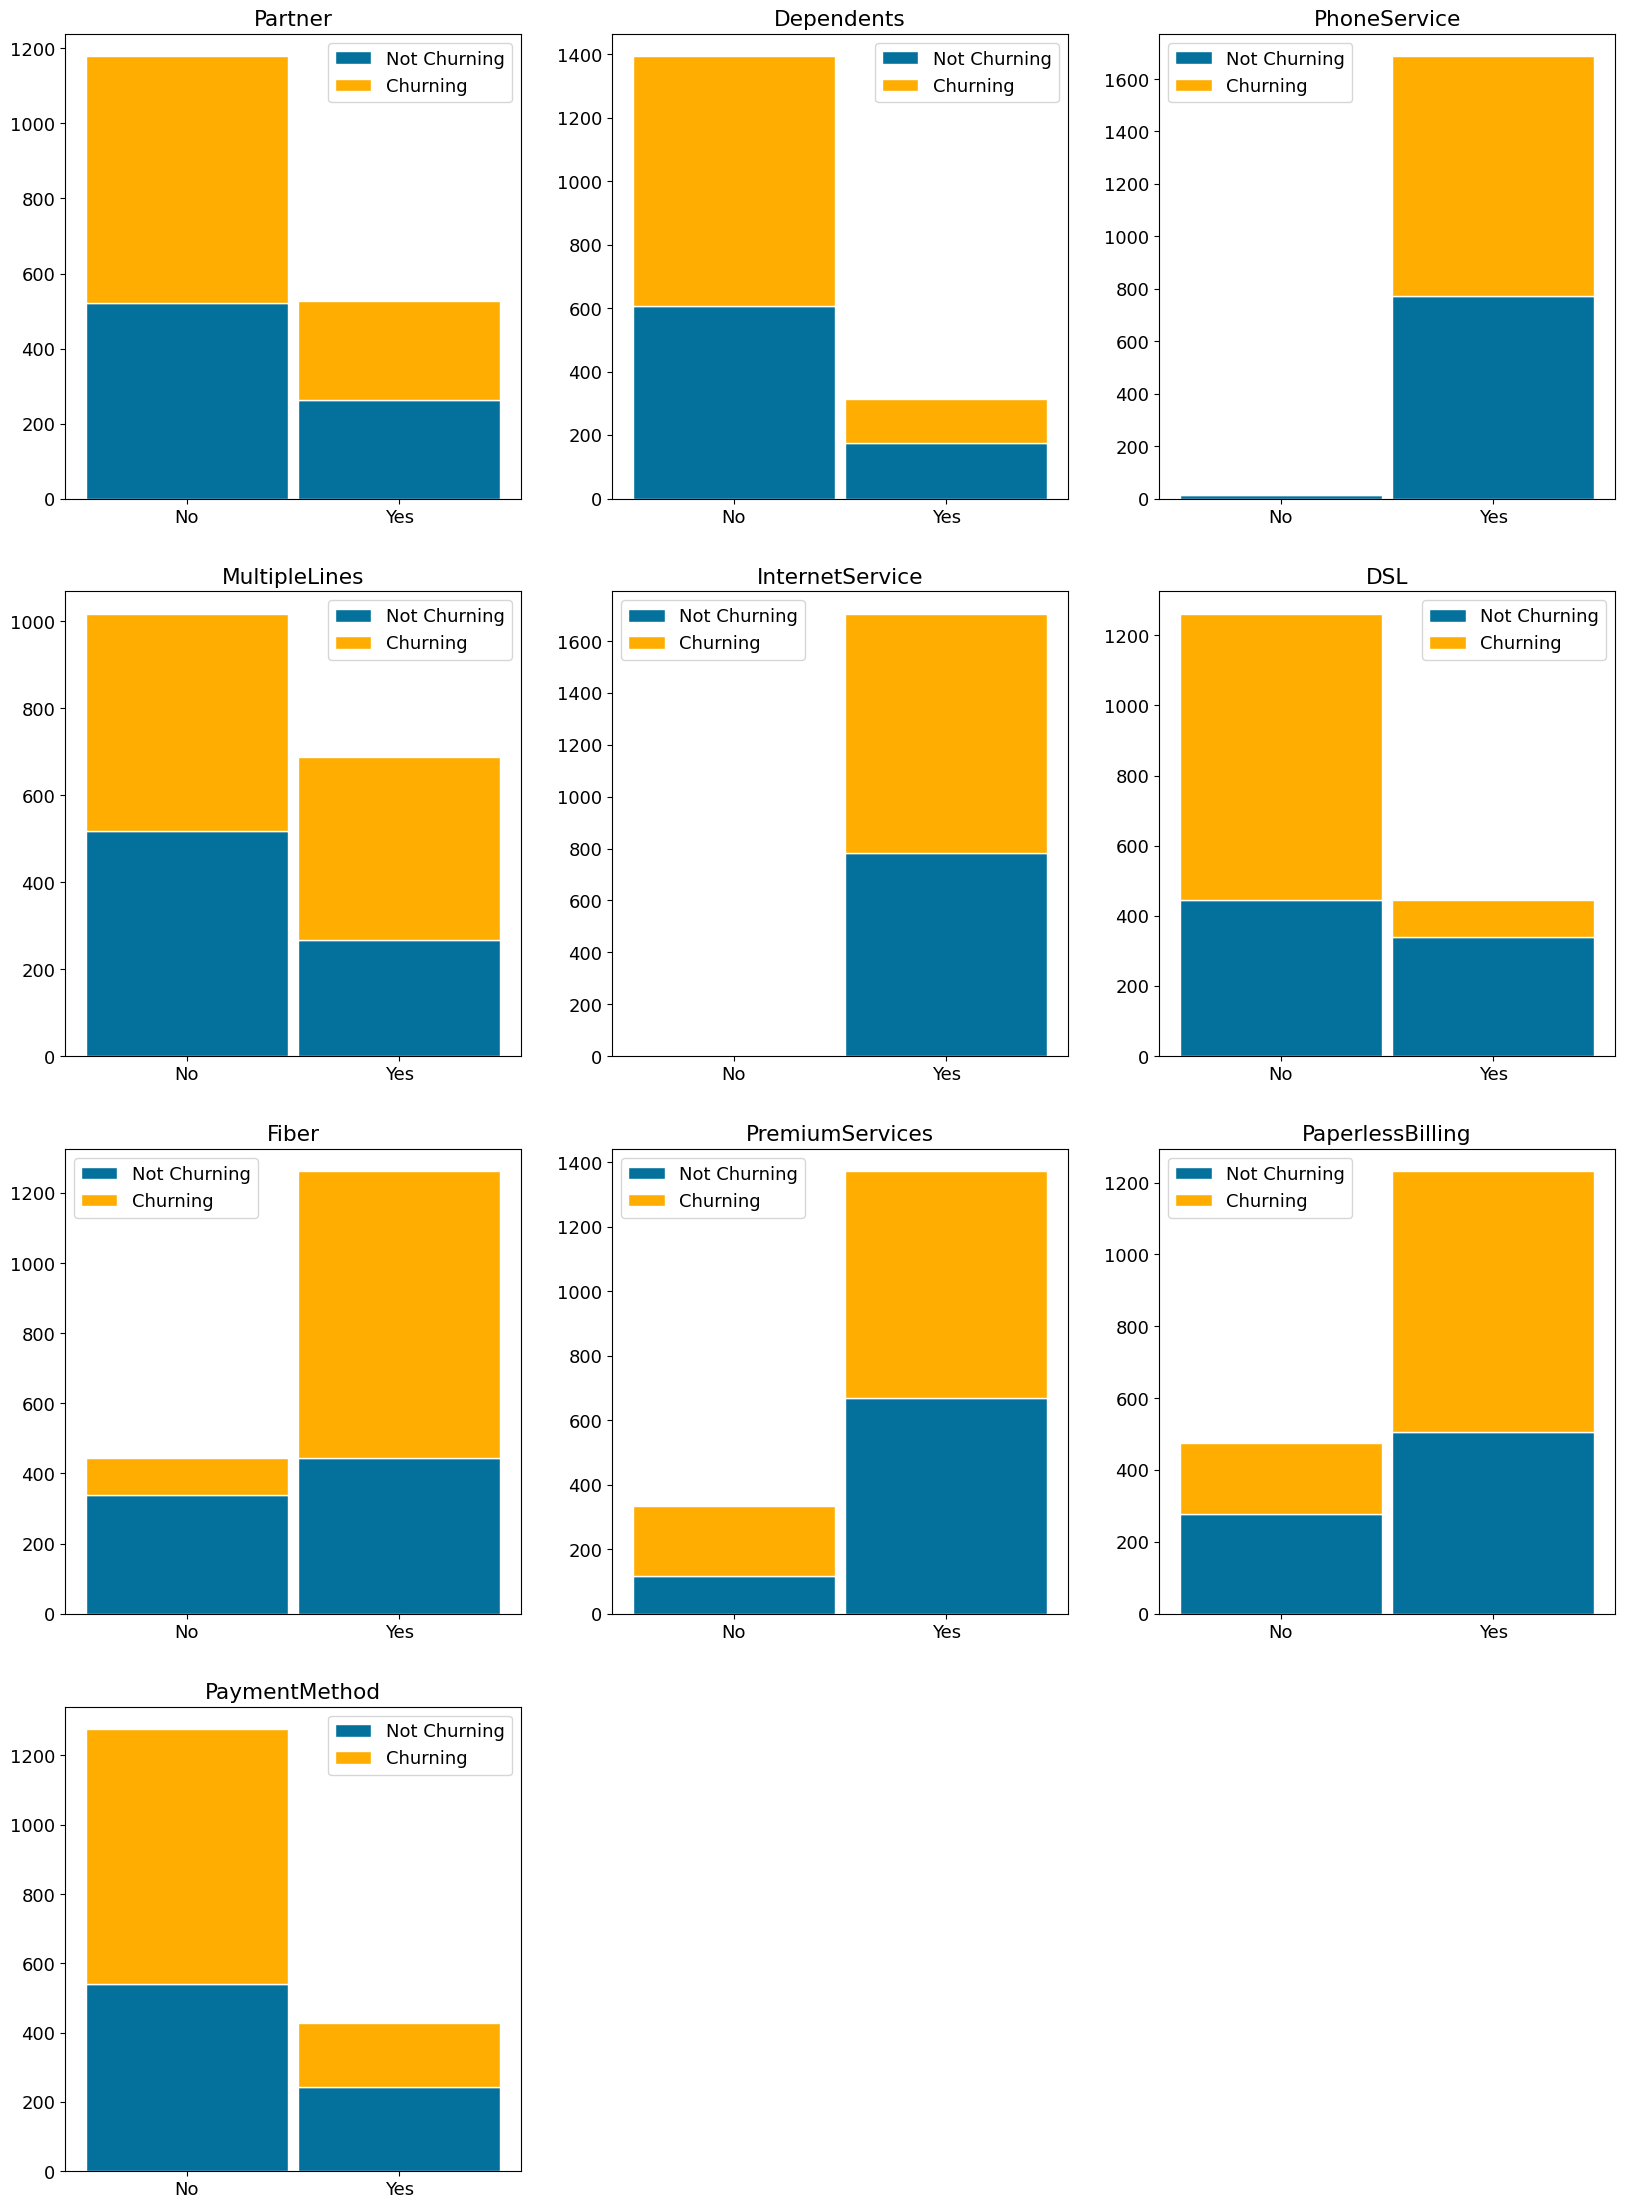

In [48]:
kmenas_cluster_0 = groups_kmeans.get_group(0)
plot_clust_distributions(kmenas_cluster_0, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'DSL',
                               'Fiber', 'PremiumServices', 'PaperlessBilling',
                               'PaymentMethod'])

In [49]:
print_cluster_describe_cat(kmenas_cluster_0)

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Churn
count,1706,1706,1706,1706,1706,1706,1706,1706,1706,1706,1706,1706,1706,1706
unique,2,2,2,2,2,2,1,2,2,2,3,2,2,2
top,0,0,0,0,1,0,1,0,1,1,0,1,0,1
freq,886,1345,1180,1394,1688,1018,1706,1262,1262,1372,1580,1232,1277,922


In [50]:
print_cluster_describe_cont(kmenas_cluster_0)

,Tenure_original,MonthlyCharges_original
count,1706.000000,1706.000000
mean,8.971864,77.745633
std,6.771280,13.210241
min,1.000000,53.650000
25%,3.000000,69.650000
50%,8.000000,76.450000
75%,14.000000,87.100000
max,26.000000,112.950000


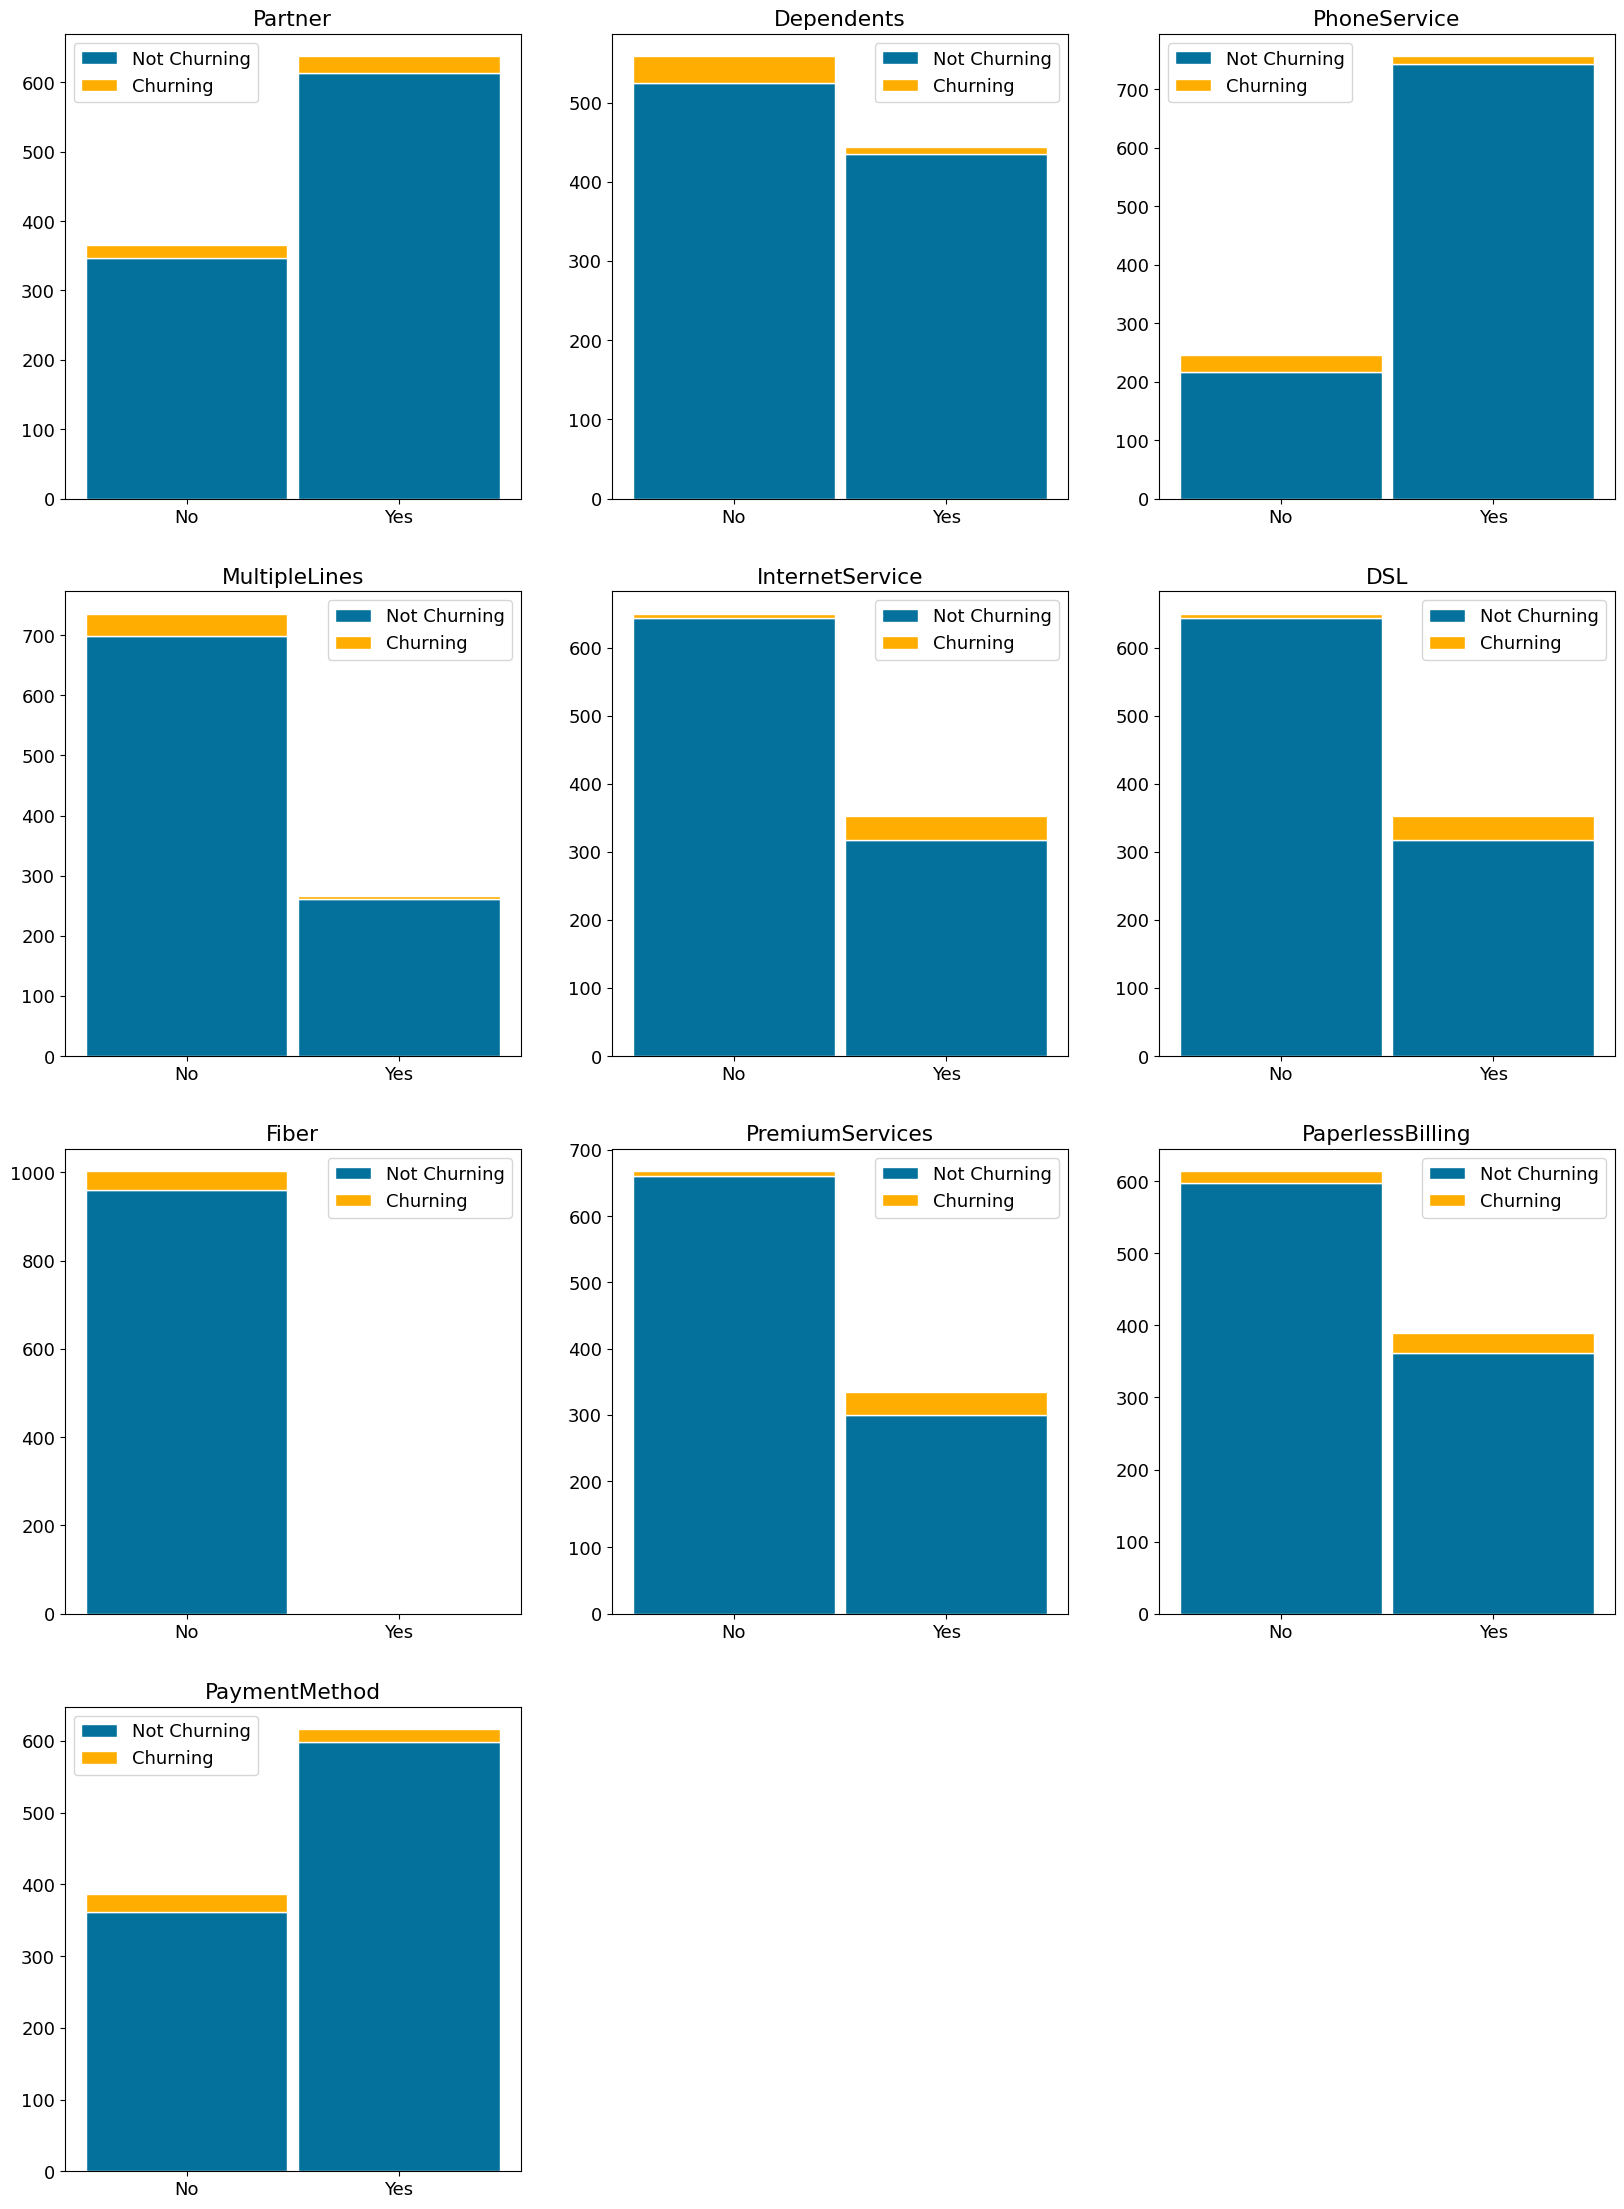

In [56]:

kmenas_cluster_1 = groups_kmeans.get_group(1)
plot_clust_distributions(kmenas_cluster_1, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'DSL',
                               'Fiber', 'PremiumServices', 'PaperlessBilling', 'PaymentMethod'])

In [57]:
print_cluster_describe_cat(kmenas_cluster_1)

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Churn
count,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003,1003
unique,2,2,2,2,2,2,2,2,1,2,3,2,2,2
top,1,0,1,0,1,0,0,0,0,0,2,0,1,0
freq,510,932,638,559,757,736,650,650,1003,668,606,614,617,960


In [58]:
print_cluster_describe_cont(kmenas_cluster_1)

,Tenure_original,MonthlyCharges_original
count,1003.000000,1003.000000
mean,55.178465,30.857478
std,11.731573,13.519111
min,33.000000,18.400000
25%,46.000000,20.050000
50%,56.000000,24.750000
75%,66.000000,42.700000
max,72.000000,62.150000


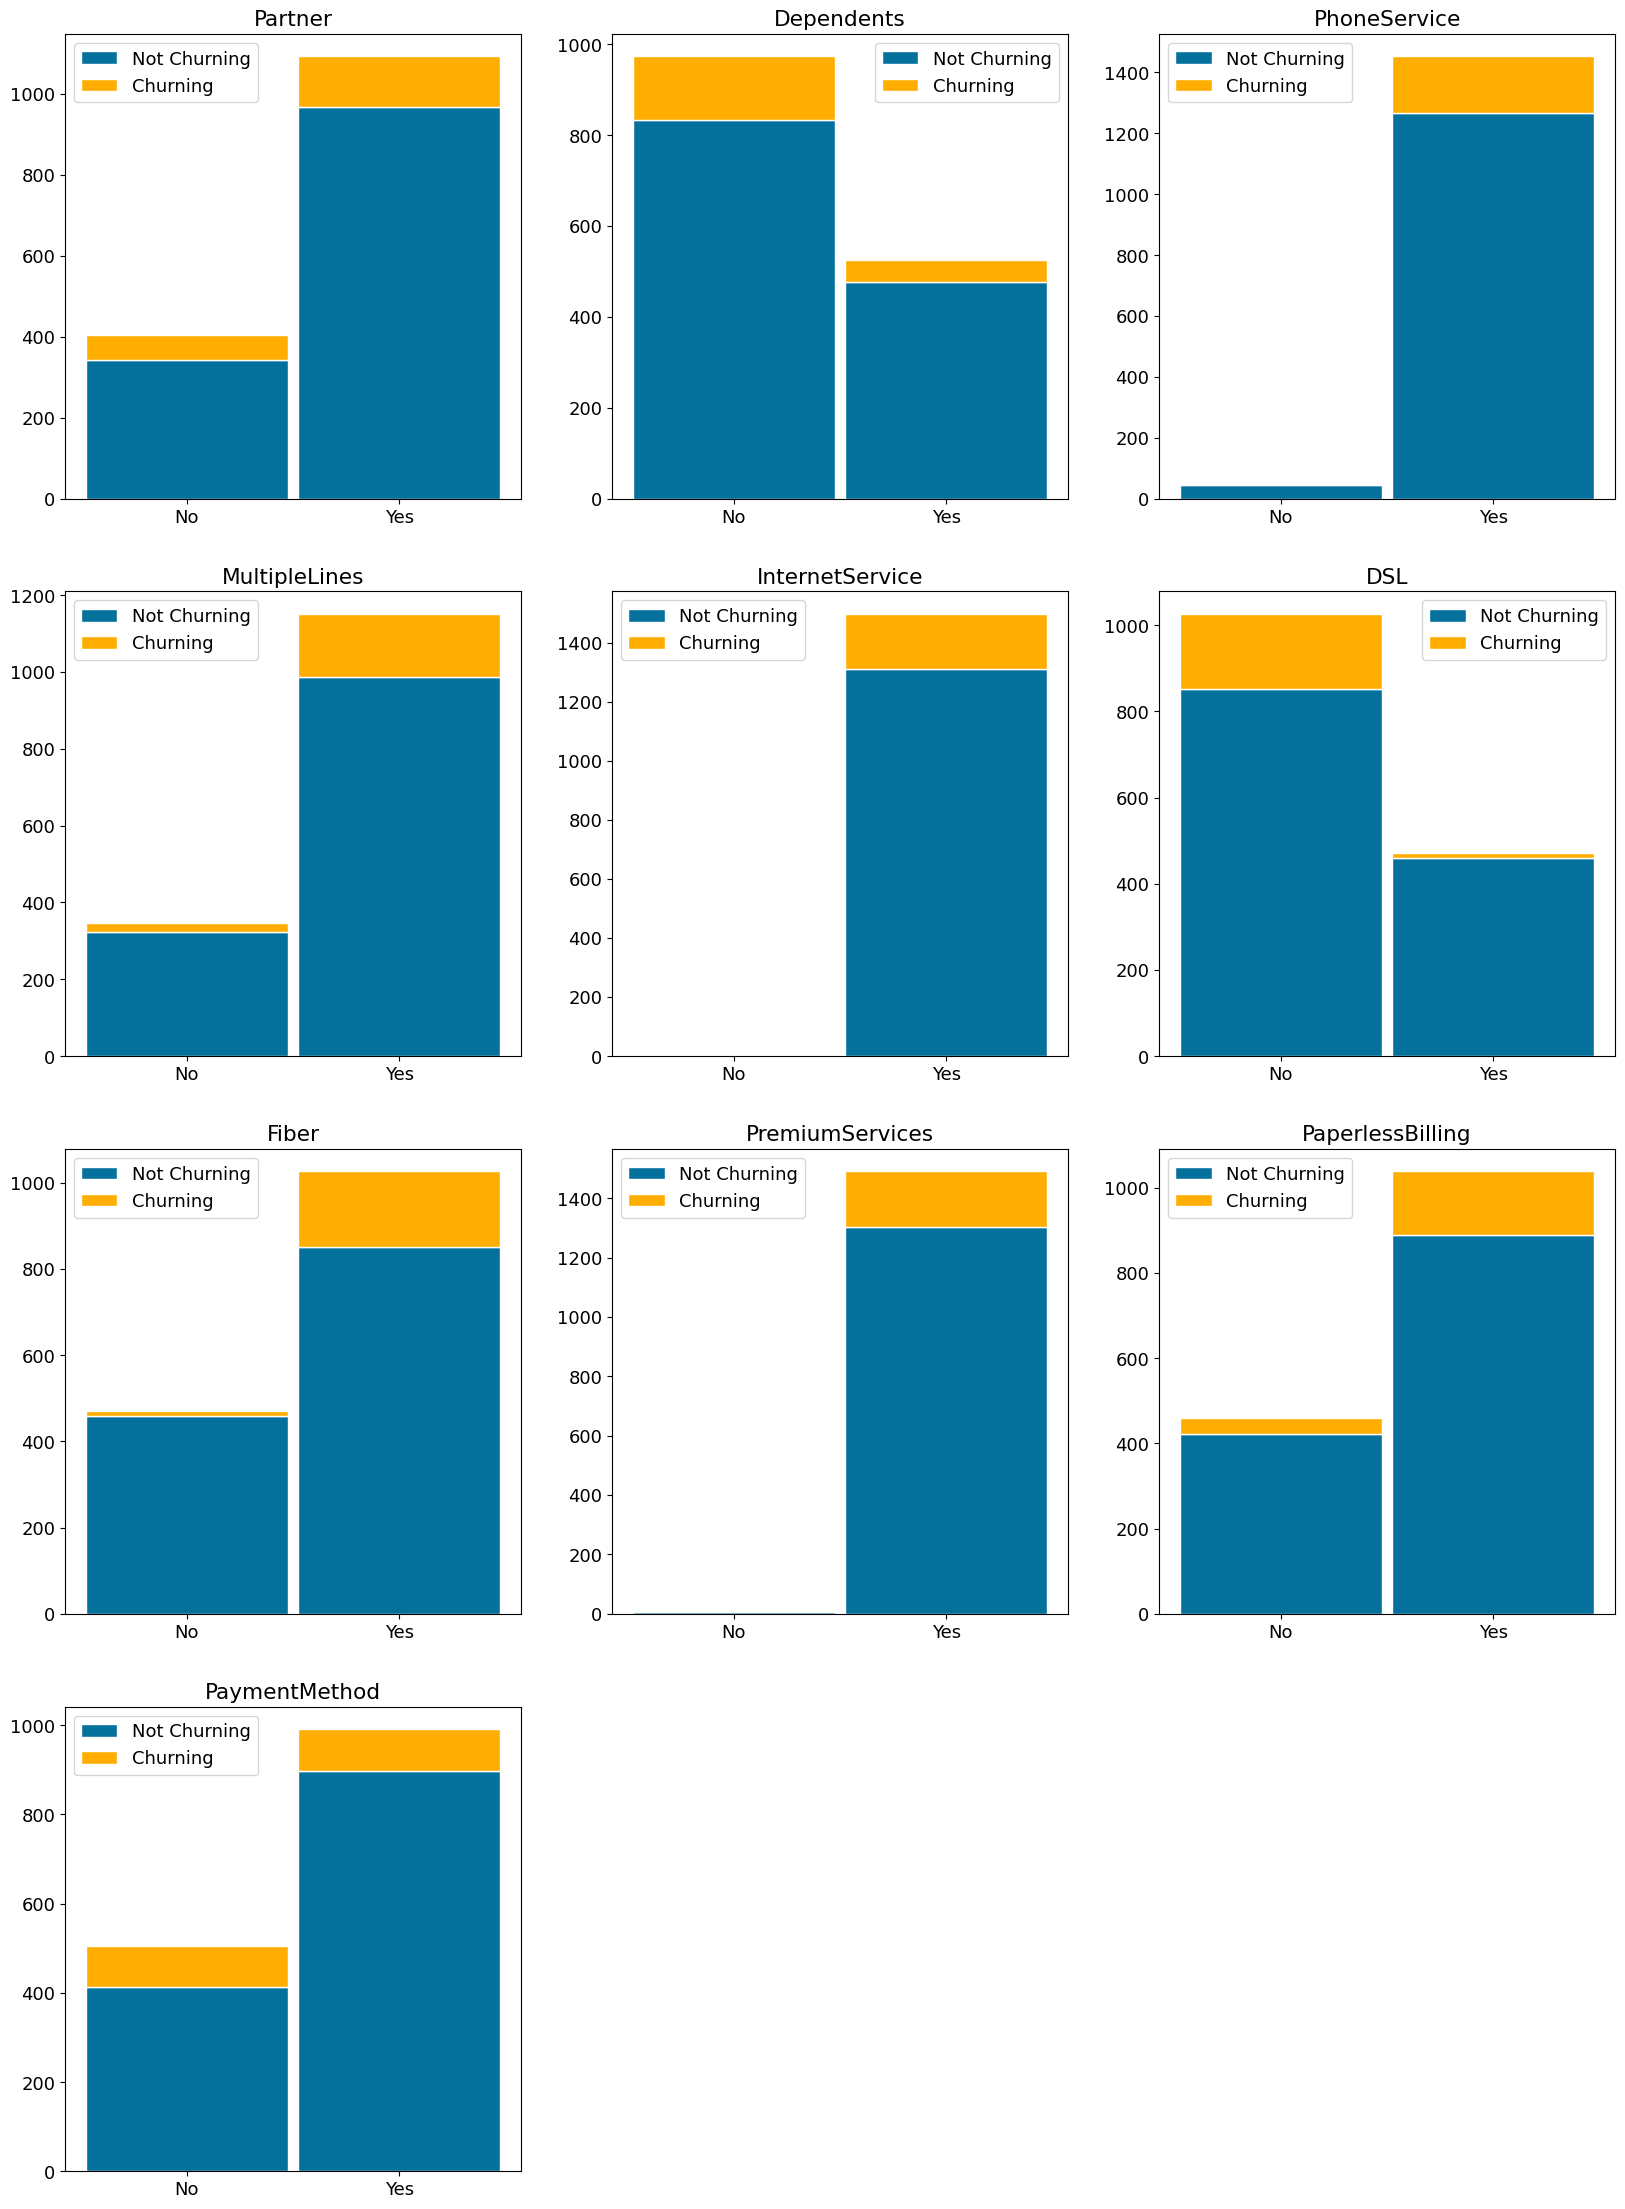

In [59]:
kmenas_cluster_2 = groups_kmeans.get_group(2)
plot_clust_distributions(kmenas_cluster_2, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'DSL',
                               'Fiber', 'PremiumServices', 'PaperlessBilling',
                               'PaymentMethod'])

In [60]:
print_cluster_describe_cat(kmenas_cluster_2)

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Churn
count,1498,1498,1498,1498,1498,1498,1498,1498,1498,1498,1498,1498,1498,1498
unique,2,2,2,2,2,2,1,2,2,2,3,2,2,2
top,1,0,1,0,1,1,1,0,1,1,2,1,1,0
freq,753,1196,1094,974,1454,1152,1498,1027,1027,1491,772,1039,992,1310


In [61]:
print_cluster_describe_cont(kmenas_cluster_2)

,Tenure_original,MonthlyCharges_original
count,1498.000000,1498.000000
mean,63.896529,93.934613
std,7.469330,14.831871
min,43.000000,55.450000
25%,58.000000,84.012500
50%,66.000000,96.050000
75%,71.000000,105.700000
max,72.000000,118.750000


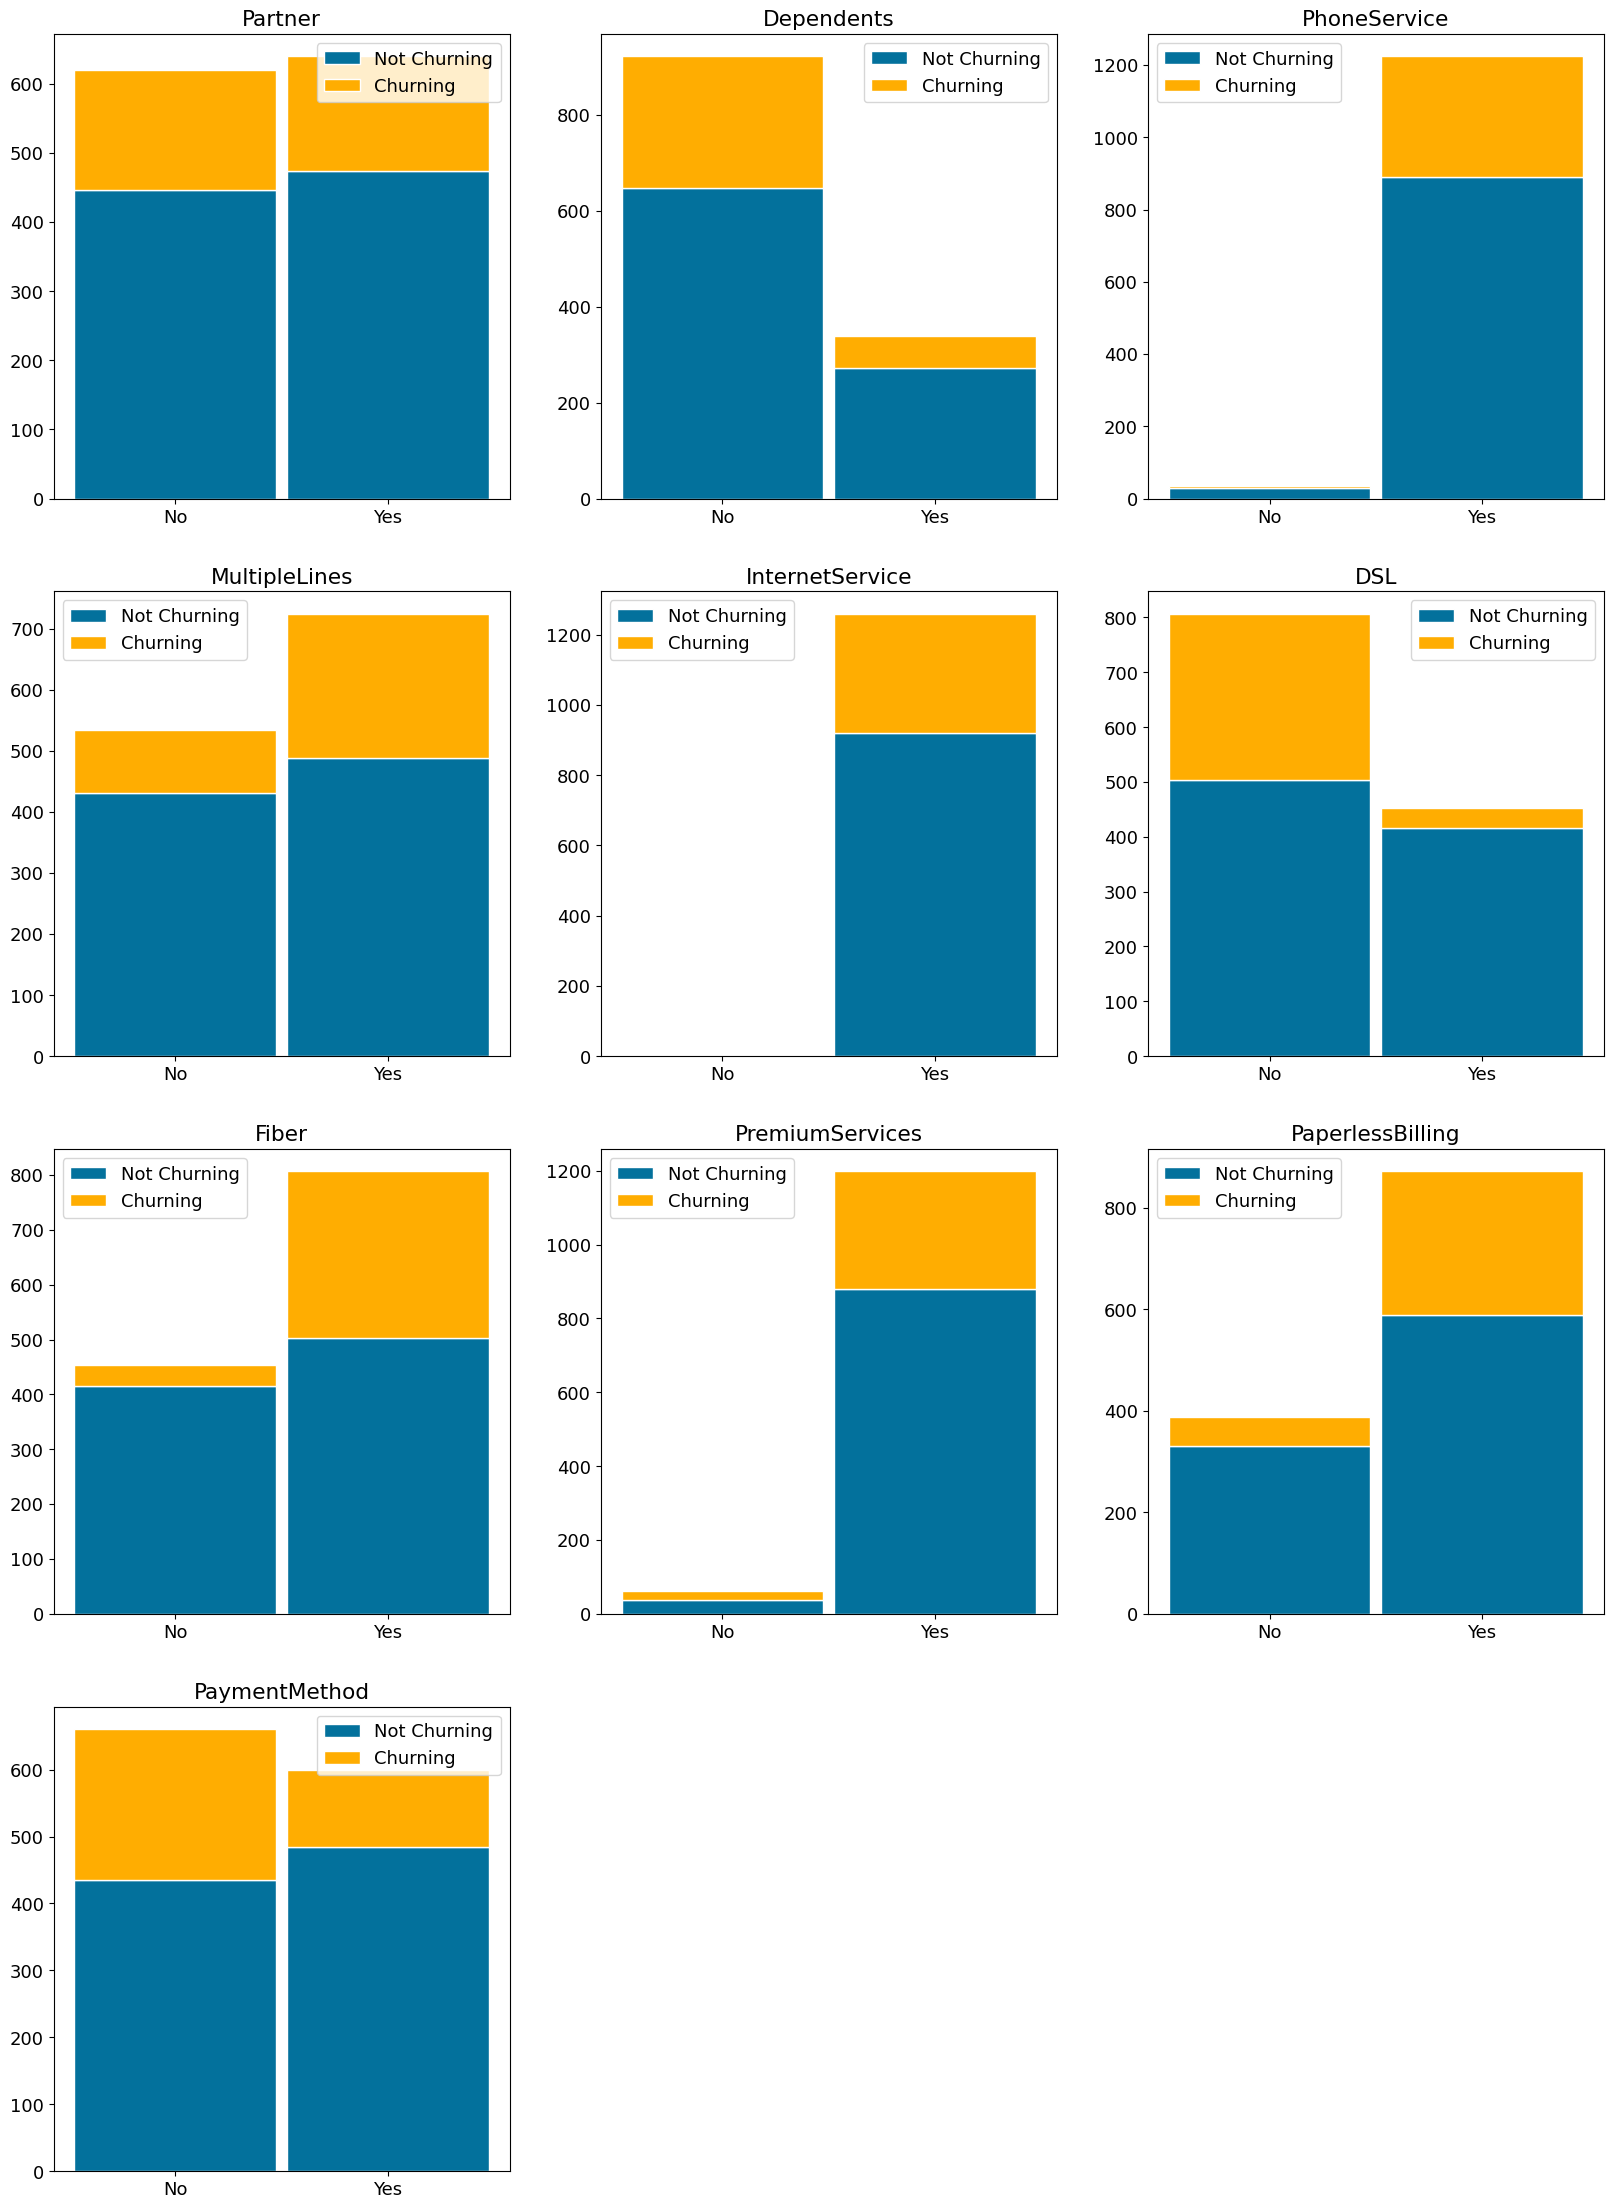

In [62]:
kmenas_cluster_3 = groups_kmeans.get_group(3)
plot_clust_distributions(kmenas_cluster_3, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'DSL',
                               'Fiber','PremiumServices', 'PaperlessBilling',
                               'PaymentMethod'])

In [63]:
print_cluster_describe_cat(kmenas_cluster_3)

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Churn
count,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260,1260
unique,2,2,2,2,2,2,1,2,2,2,3,2,2,2
top,1,0,1,0,1,1,1,0,1,1,0,1,0,0
freq,648,962,640,922,1225,725,1260,807,807,1199,768,872,661,919


In [64]:
print_cluster_describe_cont(kmenas_cluster_3)

,Tenure_original,MonthlyCharges_original
count,1260.000000,1260.000000
mean,35.821429,82.957222
std,8.632503,15.290879
min,20.000000,48.800000
25%,29.000000,70.987500
50%,35.000000,84.300000
75%,42.000000,95.012500
max,58.000000,116.250000


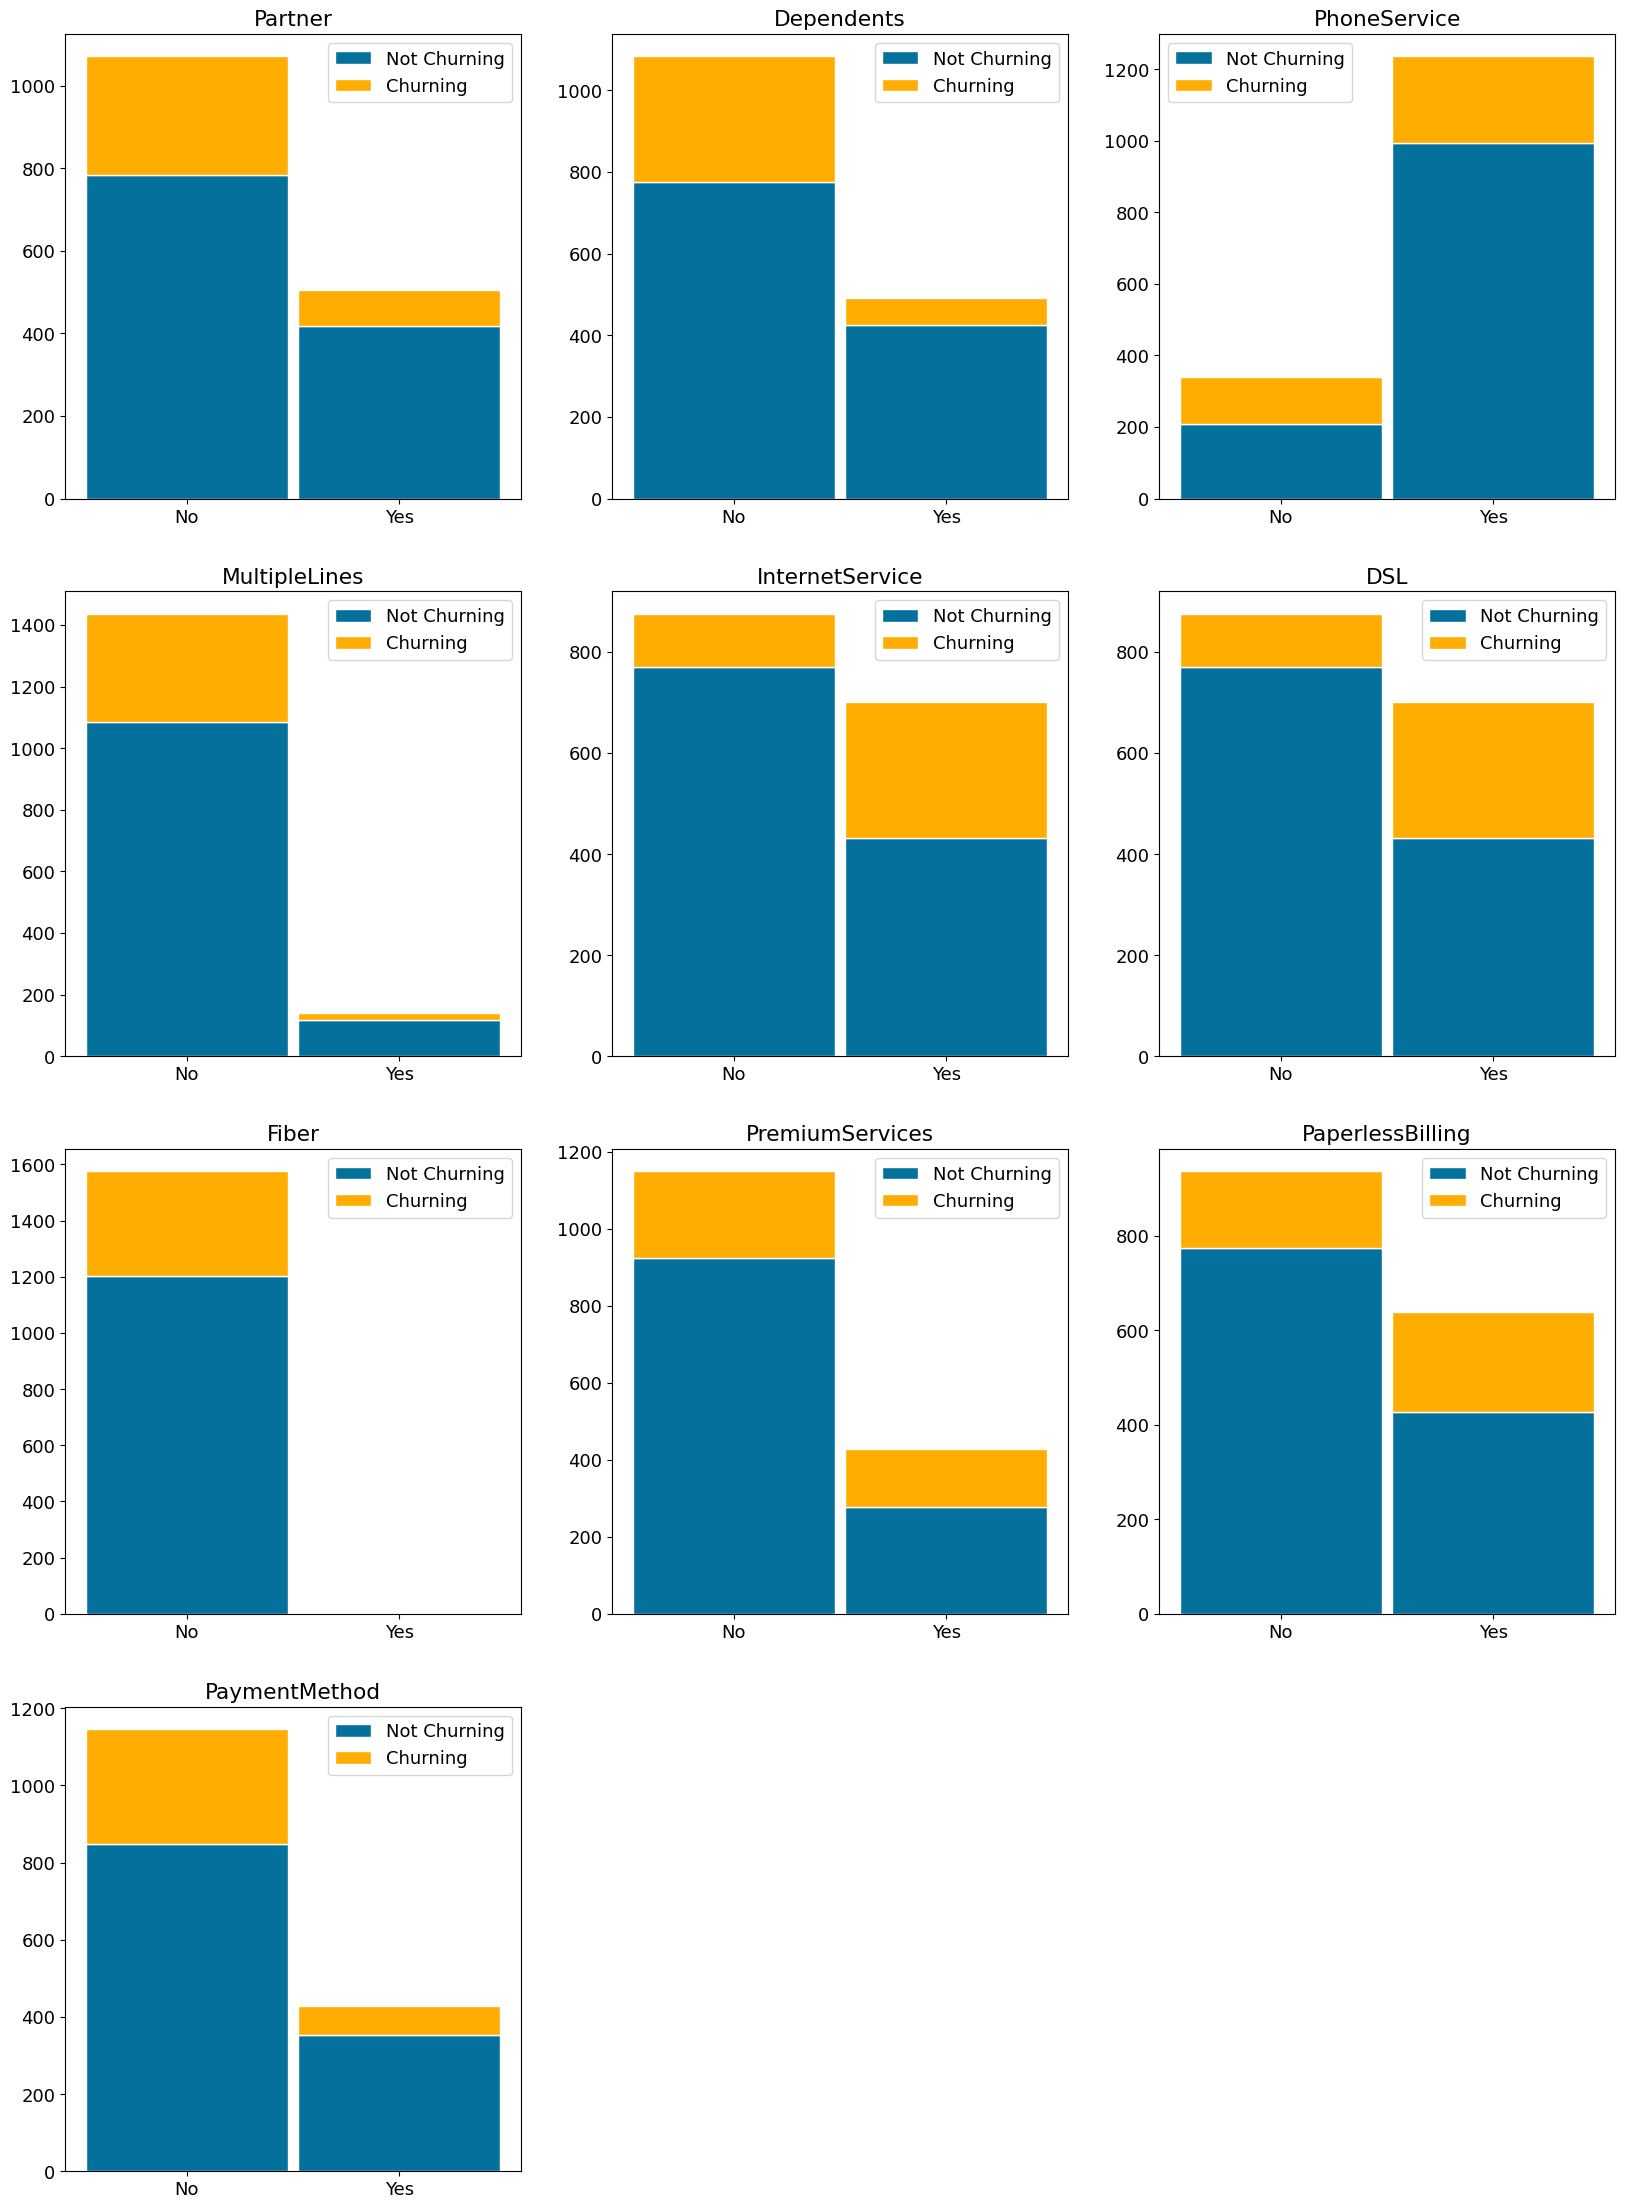

In [65]:
kmenas_cluster_4 = groups_kmeans.get_group(4)
plot_clust_distributions(kmenas_cluster_4, ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'DSL',
                               'Fiber', 'PremiumServices', 'PaperlessBilling', 'PaymentMethod'])

In [66]:
print_cluster_describe_cat(kmenas_cluster_4)

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Churn
count,1576,1576,1576,1576,1576,1576,1576,1576,1576,1576,1576,1576,1576,1576
unique,2,2,2,2,2,2,2,2,1,2,3,2,2,2
top,1,0,0,0,1,0,0,0,0,0,0,0,0,0
freq,824,1466,1072,1084,1237,1437,876,876,1576,1149,1119,937,1147,1201


In [67]:
print_cluster_describe_cont(kmenas_cluster_4)

,Tenure_original,MonthlyCharges_original
count,1576.000000,1576.000000
mean,10.461929,30.007836
std,9.360088,12.225796
min,0.000000,18.250000
25%,2.000000,20.000000
50%,8.000000,24.075000
75%,18.000000,44.400000
max,33.000000,80.850000


In [75]:
data_plotclust.to_csv('datapostclust_21_05.csv', index=False)

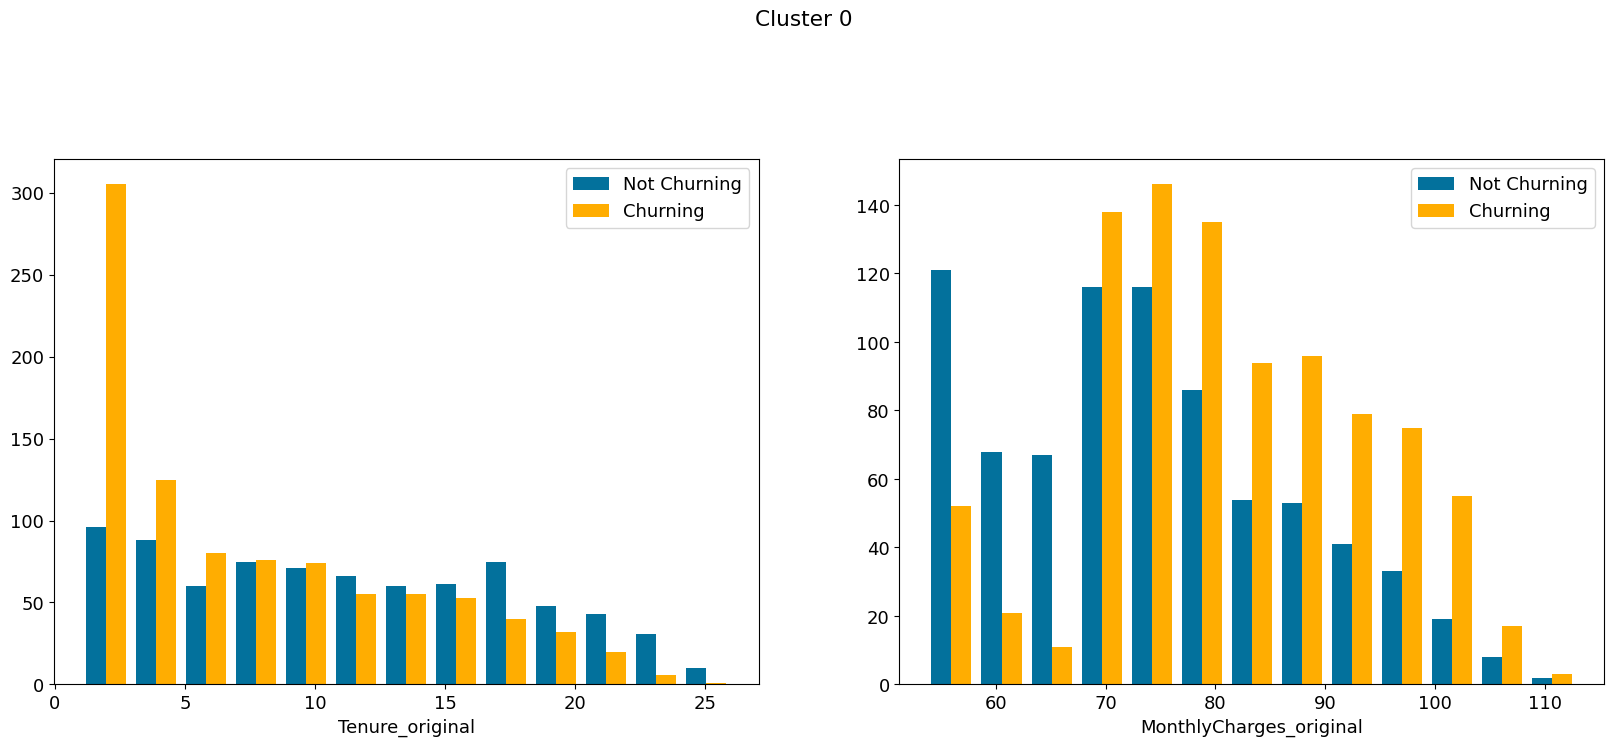

In [68]:
plot_cont_clust(kmenas_cluster_0, 0)

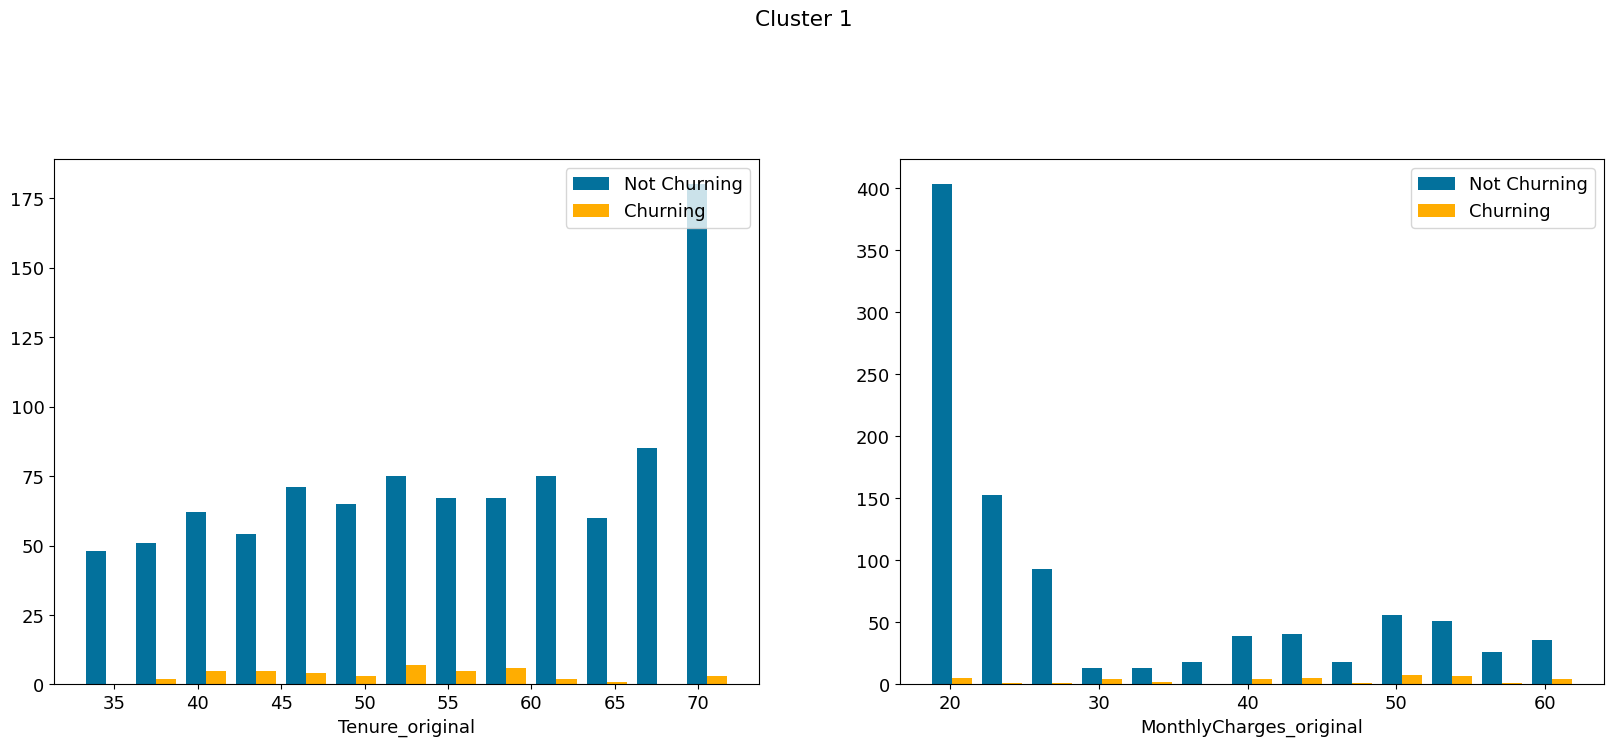

In [69]:
plot_cont_clust(kmenas_cluster_1, 1)

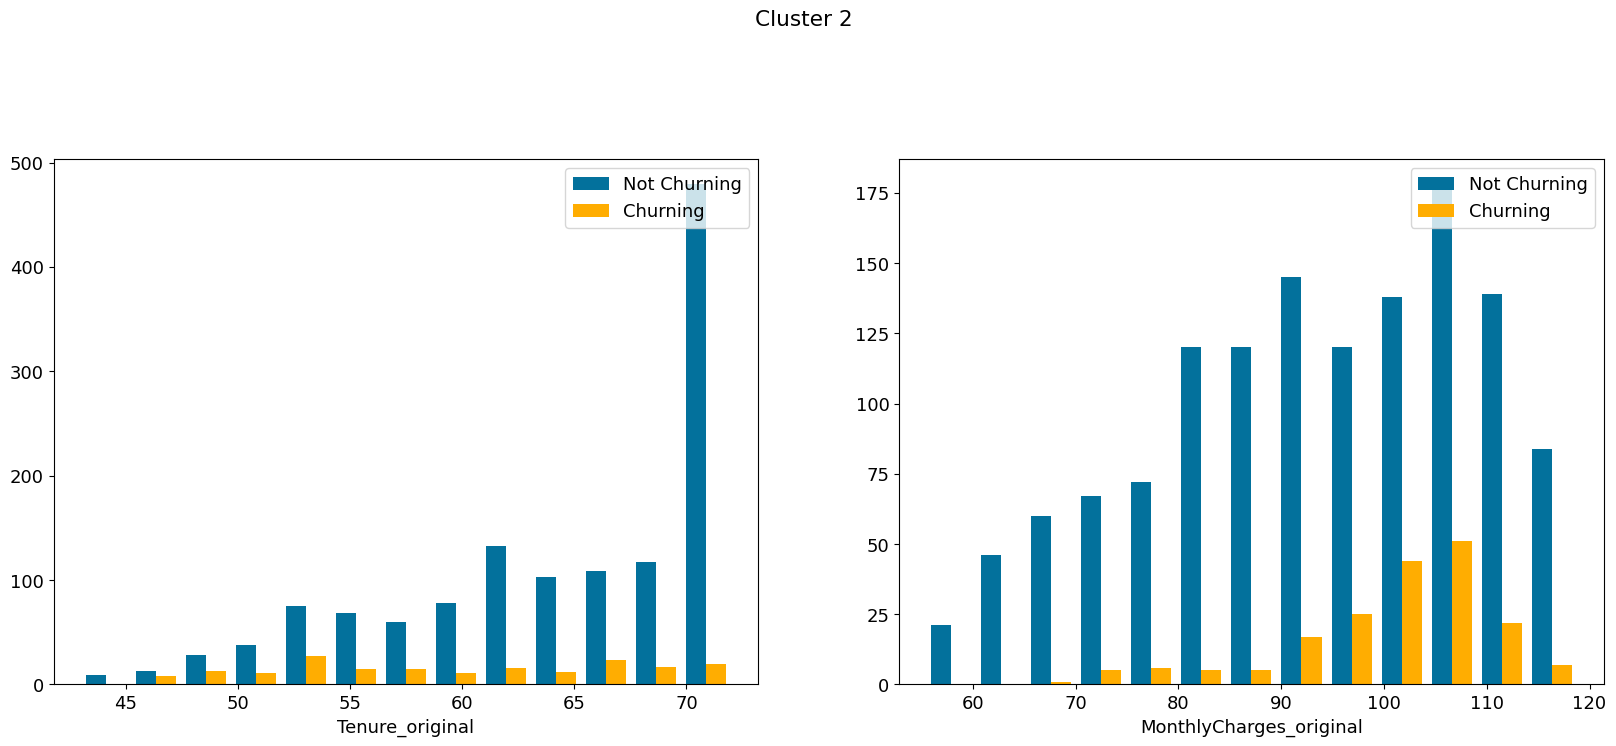

In [70]:
plot_cont_clust(kmenas_cluster_2, 2)

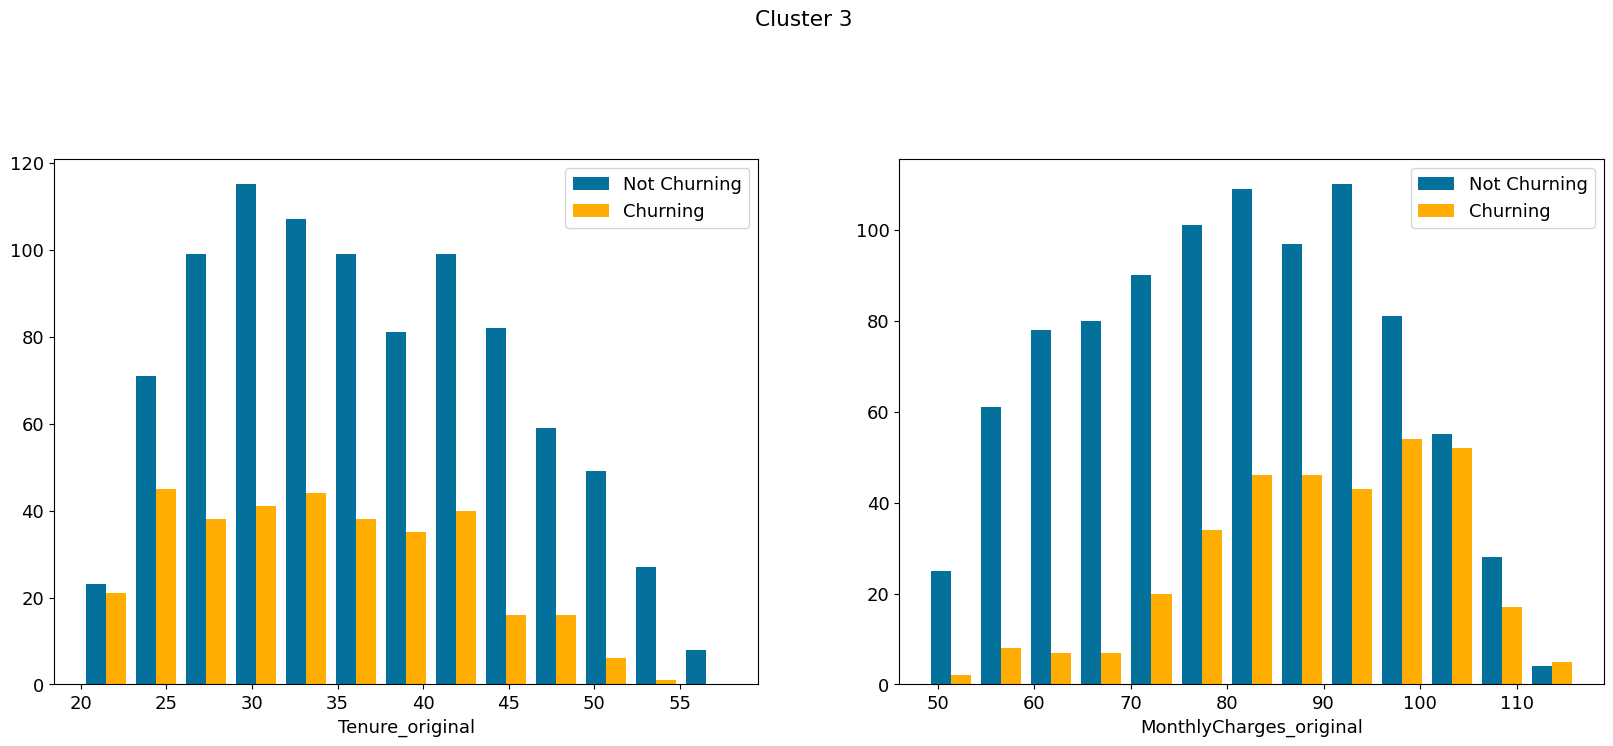

In [71]:
plot_cont_clust(kmenas_cluster_3, 3)

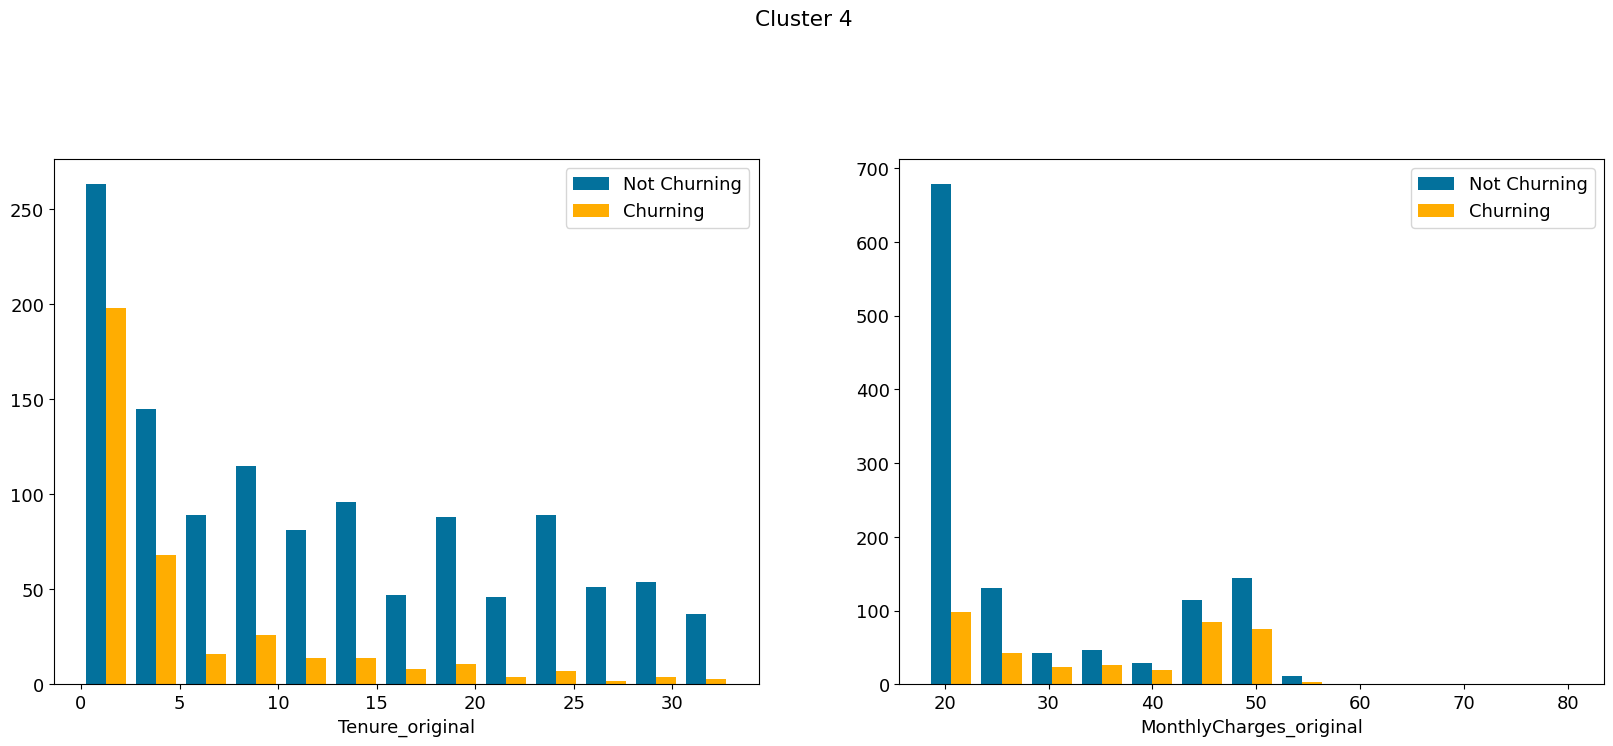

In [72]:
plot_cont_clust(kmenas_cluster_4, 4)

# Hierarchical Clustering

In [73]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, complete, fcluster, cut_tree

In [76]:
data_postclust = pd.read_csv('datapostclust_21_05.csv')

In [77]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [78]:
Z = linkage(x_cluster, 'complete')

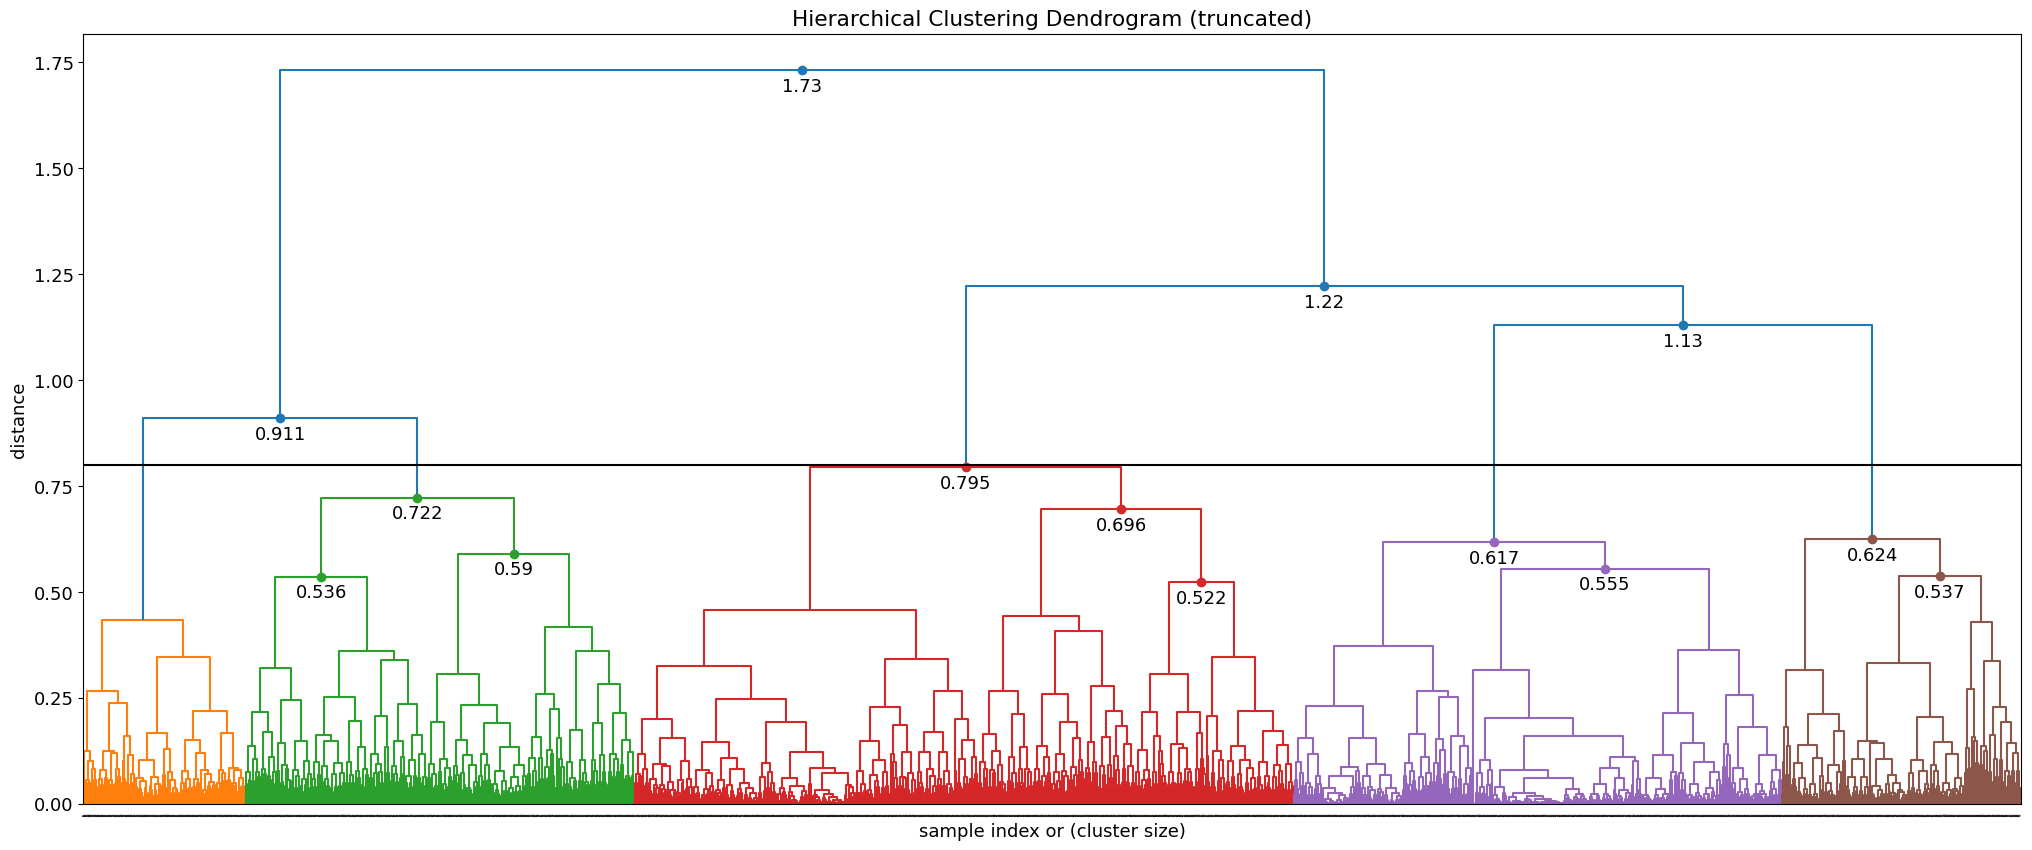

In [79]:
plt.figure(figsize=(25,10))
fancy_dendrogram(
    Z,
    truncate_mode='level',
    p=30,
    leaf_rotation=45.,
    leaf_font_size=0.,
    show_contracted=True,
    annotate_above=0.5,
    max_d=0.80,
)
plt.show()

In [80]:
Z

array([[2.20000000e+01, 1.33800000e+03, 0.00000000e+00, 2.00000000e+00],
       [3.30000000e+01, 1.00000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.81000000e+02, 1.24300000e+03, 0.00000000e+00, 2.00000000e+00],
       ...,
       [1.40760000e+04, 1.40770000e+04, 1.12955909e+00, 2.64200000e+03],
       [1.40800000e+04, 1.40820000e+04, 1.22188278e+00, 5.03900000e+03],
       [1.40810000e+04, 1.40830000e+04, 1.73123019e+00, 7.04300000e+03]])

In [81]:
test_labels_hier = fcluster(Z, 0.8, criterion='distance')

In [82]:
# data_plotclust['label_hier_complete'] = test_labels_hier
# data_postdbscan['label_hier_complete'] = test_labels_hier
data_postclust['label_hier_complete'] = test_labels_hier

In [83]:
Z2 = linkage(x_cluster, 'single')

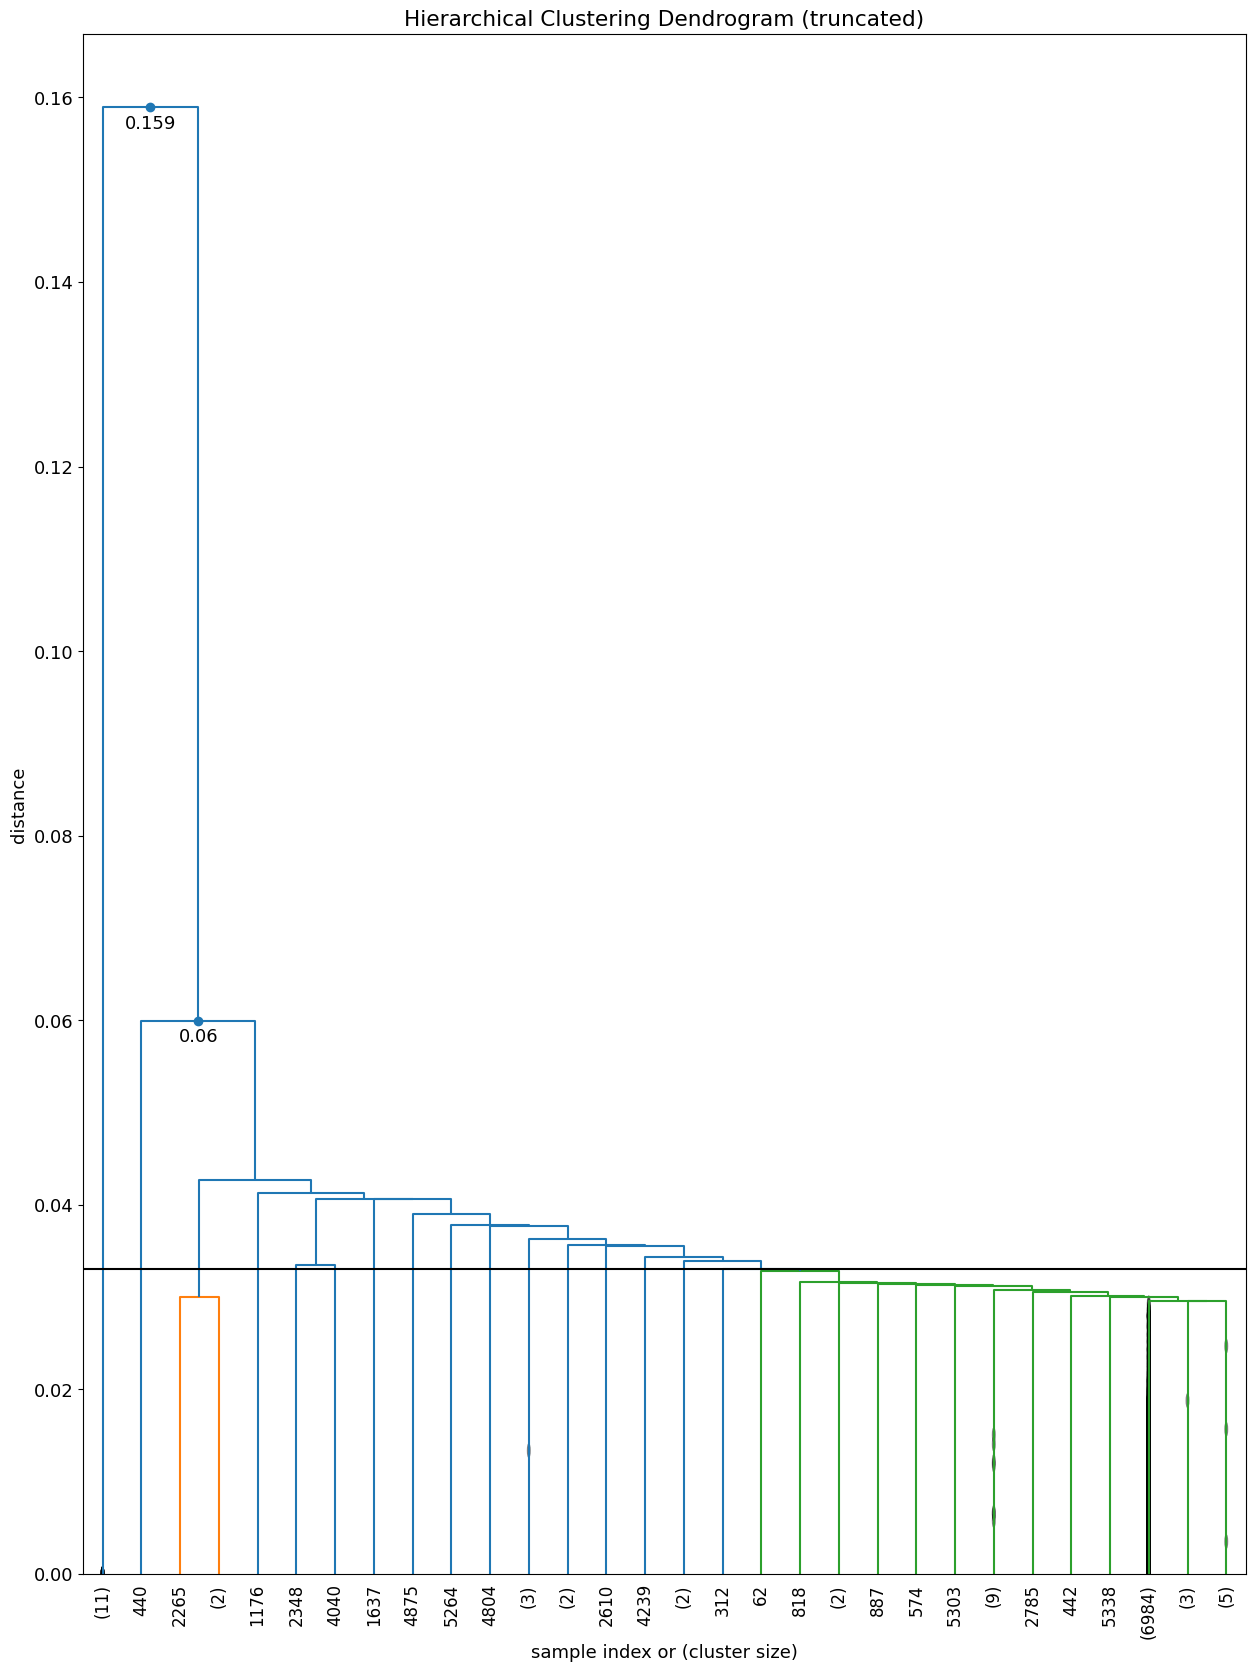

In [84]:
plt.figure(figsize=(15,20))
fancy_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=0.05,
    max_d=0.033,
)
plt.show()

In [85]:
data_postclust['label_hier_complete'].unique()

array([4, 3, 5, 2, 1], dtype=int32)

# Association Rules Part

In [92]:
import fim

In [ ]:
data_biggroup_mining = data_biggroup.copy()
data_biggroup_mining.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharges,Churn
0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0
1,1,0,0,0,1,0,1,1,0,1,1,0,0,6,5,0
2,1,0,0,0,1,0,1,1,0,1,0,1,0,0,4,1
3,1,0,0,0,0,0,1,1,0,1,1,0,1,8,3,0
4,0,0,0,0,1,0,1,0,1,0,0,1,0,0,6,1


In [ ]:
data_biggroup_mining_reduced = data_biggroup_mining[['PhoneService', 'InternetService', 'DSL', 'Fiber', 'PremiumServices', 'Contract',
                                                     'PaperlessBilling', 'PaymentMethod', 'Tenure', 'MonthlyCharges', 'Churn']]
new_name_reduced = ['_phSer', '_intSer', '_DSL', '_Fiber', '_premServ', '_contr', '_pLBil', '_paMe', '_tenure', '_monCh', '_churn']
for i, col_name in enumerate(data_biggroup_mining_reduced.columns):
    data_biggroup_mining_reduced[col_name] = data_biggroup_mining_reduced[col_name].astype(str) + str(new_name_reduced[i])

/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [ ]:
data_biggroup_mining_reduced.head()

,PhoneService,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharges,Churn
0,0_phSer,1_intSer,1_DSL,0_Fiber,1_premServ,0_contr,1_pLBil,0_paMe,0_tenure,1_monCh,0_churn
1,1_phSer,1_intSer,1_DSL,0_Fiber,1_premServ,1_contr,0_pLBil,0_paMe,6_tenure,5_monCh,0_churn
2,1_phSer,1_intSer,1_DSL,0_Fiber,1_premServ,0_contr,1_pLBil,0_paMe,0_tenure,4_monCh,1_churn
3,0_phSer,1_intSer,1_DSL,0_Fiber,1_premServ,1_contr,0_pLBil,1_paMe,8_tenure,3_monCh,0_churn
4,1_phSer,1_intSer,0_DSL,1_Fiber,0_premServ,0_contr,1_pLBil,0_paMe,0_tenure,6_monCh,1_churn


In [ ]:
new_name = ['_gen', '_sen', '_par', '_dep', '_phSer', '_mulLin', '_intSer', '_DSL', '_Fiber',
            '_premServ', '_contr', '_pLBil', '_paMe', '_tenure', '_monCh', '_churn']
for i, col_name in enumerate(data_biggroup.columns):
    data_biggroup_mining[col_name] = data_biggroup_mining[col_name].astype(str) + str(new_name[i])

In [ ]:
data_biggroup_mining.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharges,Churn
0,0_gen,0_sen,1_par,0_dep,0_phSer,0_mulLin,1_intSer,1_DSL,0_Fiber,1_premServ,0_contr,1_pLBil,0_paMe,0_tenure,1_monCh,0_churn
1,1_gen,0_sen,0_par,0_dep,1_phSer,0_mulLin,1_intSer,1_DSL,0_Fiber,1_premServ,1_contr,0_pLBil,0_paMe,6_tenure,5_monCh,0_churn
2,1_gen,0_sen,0_par,0_dep,1_phSer,0_mulLin,1_intSer,1_DSL,0_Fiber,1_premServ,0_contr,1_pLBil,0_paMe,0_tenure,4_monCh,1_churn
3,1_gen,0_sen,0_par,0_dep,0_phSer,0_mulLin,1_intSer,1_DSL,0_Fiber,1_premServ,1_contr,0_pLBil,1_paMe,8_tenure,3_monCh,0_churn
4,0_gen,0_sen,0_par,0_dep,1_phSer,0_mulLin,1_intSer,0_DSL,1_Fiber,0_premServ,0_contr,1_pLBil,0_paMe,0_tenure,6_monCh,1_churn


In [ ]:
class Decoded_rules():
    def __init__(self, encoded_rules):
        self.encoded_rules = encoded_rules
        self.tree = {}
        self._init_tree()
        self.tree_keys = None

    def _init_tree(self):
        set_keys = list()
        for key in self.encoded_rules:
            set_keys.append(key['target'])
        set_keys = set(set_keys)
        for key in set_keys:
            self.tree[key] = list()
        # populate the tree
        for rule in self.encoded_rules:
            tar = rule['target']
            self.tree[tar].append((rule['rule'], rule['asb_support'], round(rule['confidence'],8), round(rule['lift'],8)))
        self.tree_keys = self.tree.keys()

    def search_rule(self, min_conf, target):
        res = list()
        for tar in target:
            if tar not in list(self.tree.keys()):
                res.append((tar, 'No Rules Found'))
            else:
                r = list()
                sub_tree = self.tree[tar]
                for rule in sub_tree:
                    if rule[-1] > min_conf:
                        r.append(rule)
                res.append((tar,r))
        return res

    def get_rule(self, index):
        rule = self.encoded_rules[index]

        pattern_rule = ''
        for elem in rule['rule']:
            pattern_rule += '\n' + elem
        tar = rule['target']
        abs_sup = rule['asb_support']
        rlt_sup = rule['rlt_support']
        conf = rule['confidence']
        lift = rule['lift']

        print(f"Target: \n{tar}\n\nRule: {pattern_rule}\n\nAbs value support: {abs_sup}\nRlt value support: {rlt_sup}\nConfidence: {conf}\nLift: {lift}")

def decode_rules(rules):
    test = list()
    rules.sort(key=lambda rule: rule[5], reverse=True)
    print(f'Found {len(rules)} rules\n')
    for rule in rules:
        decoded = {'target':rule[0], 'rule':rule[1], 'asb_support':rule[2], 'rlt_support':rule[3], 'confidence':rule[4], 'lift':rule[5]}
        test.append(decoded)

    dec_rules = Decoded_rules(test)
    return dec_rules, test

In [ ]:
def print_rule(temp):
    target = temp[0]
    final = 'Target: ' + str(target) + '\n\n'
    _temp = temp
    for elem in temp[1]:
        temp = elem.split('_')

        if temp[1] == 'gen':
            inv_map_val = {0:'Female Customer', 1:'Male Customer'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'sen':
            inv_map_val = {0:'No Internet Service', 1:'Yes Internet Service'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'par':
            inv_map_val = {0:'No Partner', 1:'Yes Partner'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'dep':
            inv_map_val = {0:'No Dependents', 1:'Yes Dependents'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'phSer':
            inv_map_val = {0:'No', 1:'Yes'}
            final += inv_map_val[int(temp[0])] + ' Phone Service\n'

        elif temp[1] == 'mulLin':
            inv_map_val = {0:'No Multi Lines', 1:'Yes Multi Lines'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'intSer':
            inv_map_val = {0:'No Internet Service', 1:'Yes Internet Service'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'DSL':
            inv_map_val = {0:'No DSL', 1:'Yes DSL'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'Fiber':
            inv_map_val = {0:'No Fiber', 1:'Yes Fiber'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'premServ':
            inv_map_val = {0:'No premium Services', 1:'Yes Premium Services'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'pLBil':
            inv_map_val = {0:'No Paperless Billing', 1:'Yes Paperless Billing'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'contr':
            inv_map_val = {0:'Month-to-month', 1:'Long-term Contract'}
            final += inv_map_val[int(temp[0])] + ' Contract\n'

        elif temp[1] == 'paMe':
            inv_map_val = {0:'Check', 1:'Automatic'}

        elif temp[1] == 'tenure':
            final += temp[0] + ' (over 13 categories) Tenure range\n'

        elif temp[1] == 'monCh':
            final += temp[0] + ' (over 13 categories) MonthlyCharges range\n'

        elif temp[1] == 'churn':
            inv_map_val = {0:'No Churn', 1:'Yes Churn'}
            final += inv_map_val[int(temp[0])] + '\n'
        else:
            final += temp[1] + ' TODO!\n'

    lift_value = _temp[-1]
    conf_value = _temp[-2]
    final += '\nConfidence score: ' + str(conf_value) + '\nLift score: ' + str(lift_value)
    print(final)

In [ ]:
def print_rule_from_tree(temp):
    target = temp[0]
    final = 'Target: ' + str(target) + '\n\n'
    _temp = temp
    for elem in temp[1][0]:
        temp = elem.split('_')
        if temp[1] == 'gen':
            inv_map_val = {0:'Female Customer', 1:'Male Customer'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'sen':
            inv_map_val = {0:'No Internet Service', 1:'Yes Internet Service'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'par':
            inv_map_val = {0:'No Partner', 1:'Yes Partner'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'dep':
            inv_map_val = {0:'No Dependents', 1:'Yes Dependents'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'phSer':
            inv_map_val = {0:'No', 1:'Yes'}
            final += inv_map_val[int(temp[0])] + ' Phone Service\n'

        elif temp[1] == 'mulLin':
            inv_map_val = {0:'No Multi Lines', 1:'Yes Multi Lines'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'intSer':
            inv_map_val = {0:'No Internet Service', 1:'Yes Internet Service'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'DSL':
            inv_map_val = {0:'No DSL', 1:'Yes DSL'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'Fiber':
            inv_map_val = {0:'No Fiber', 1:'Yes Fiber'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'premServ':
            inv_map_val = {0:'No premium Services', 1:'Yes Premium Services'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'pLBil':
            inv_map_val = {0:'No Paperless Billing', 1:'Yes Paperless Billing'}
            final += inv_map_val[int(temp[0])] + '\n'

        elif temp[1] == 'contr':
            inv_map_val = {0:'Month-to-month', 1:'Long-term Contract'}
            final += inv_map_val[int(temp[0])] + ' Contract\n'

        elif temp[1] == 'paMe':
            inv_map_val = {0:'Check', 1:'Automatic'}

        elif temp[1] == 'tenure':
            final += temp[0] + ' (over 13 categories) Tenure range\n'

        elif temp[1] == 'monCh':
            final += temp[0] + ' (over 13 categories) MonthlyCharges range\n'

        elif temp[1] == 'churn':
            inv_map_val = {0:'No Churn', 1:'Yes Churn'}
            final += inv_map_val[int(temp[0])] + '\n'
        else:
            final += temp[1] + ' TODO!\n'

    lift_value = _temp[1][-1]
    conf_value = _temp[1][-2]
    final += '\nConfidence score: ' + str(conf_value) + '\nLift score: ' + str(lift_value)
    print(final)

In [ ]:
def explore_tree_todepth(decoded_rules, depth):
    for target in decoded_rules.tree.keys():
        print('#'*50)
        print(f'TARGET: {target}')
        if len(decoded_rules.tree[target]) == 0:
            print(f'Couldn\'t found any rule for {target}')
        else:
            if len(decoded_rules.tree[target]) > depth:
                for i in range(depth):
                    print(f'_____________________________________________________\n\nRule {i} of {depth}:')
                    print_rule_from_tree((target, decoded_rules.tree[target][i]))
                    print('\n')
            else:
                max_len = len(decoded_rules.tree[target])
                for i in range(max_len):
                    print(f'_____________________________________________________\n\nRule {i} of {max_len}:')
                    print_rule_from_tree((target, decoded_rules.tree[target][i]))
                    print('\n')

In [ ]:
def rule_based_classifier(data, target, rules, verbose=False):
    dict_affix_column = {'tenure':'Tenure','totCh':'TotalCharges','monCh':'MonthlyCharges','webSer':'InternetService',
                         'teSup': 'TechSupport','onSec':'OnlineSecurity','onBk':'OnlineBackup','dvPro':'DeviceProtection',
                         'strTv':'StreamingTv','strMv':'StreamingMovies','contr':'Contract','churn':'Churn',
                         'pLBil':'PaperlessBilling','phSer':'PhoneService','gen':'Gender','sen':'SeniorCitizen',
                         'par':'Partner','dep':'Dependents','mulLin':'MultipleLines',
                         'paMe':'PaymentMethod','strServ':'StreamingService', 'intSer':'InternetService',
                        'DSL':'DSL', 'Fiber':'Fiber', 'premServ':'PremiumServices'}
    r = list()

    churning=True

    for i in range(len(data)):
        if verbose:
            print(f'For sample at index {i}')
        r_temp = list()
        for rule in rules:
            _temp_rule_for_sample = list()
            for flag in rule[0]:
                _flag = flag.split('_')
                if churning:
                    _temp_rule_for_sample.append(data.iloc[i][dict_affix_column[_flag[1]]] == flag)
                else:
                    _temp_rule_for_sample.append(data.iloc[i][dict_affix_column[_flag[1]]] != flag)
            r_temp.append((all(_temp_rule_for_sample)))
        if verbose:
            print(f'\nList of bool for sample: {r_temp}')
            print(f'Final bool for sample at index {i}: {all(r_temp)}')
            print(f'Appendig as final result for this sample: {any(r_temp)}\n')
            print('#'*100)
        r.append(any(r_temp))
    return r

In [ ]:
def evaluate_rule_based(data, target_val, pred, is_target_rule_0_churn):
    temp_acc = 0
    tp = 1
    tn = 1
    fp = 1
    fn = 1

    for i, result in enumerate(pred):
        temp = (data['Churn'].iloc[i].split('_')[0])

        if is_target_rule_0_churn:
            result = not(result)

        if result == int(data[target_val].iloc[i].split('_')[0]):
            temp_acc += 1
            if result == 1:
                tp += 1
            else:
                tn += 1
        else:
            if result == 1:
                fp += 1
            else:
                fn += 1

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    f1 = 2 * ((precision*recall)/(precision+recall))
    res = [accuracy, precision, recall, f1]
    return res

**Association Rules**

In [ ]:
basket = data_biggroup_mining.values
rules = fim.apriori(basket, supp=20, zmin=2, target='r', conf=80, report='ascl')

In [ ]:
decoded_rules, ordered_rules = decode_rules(rules)
explore_tree_todepth(decoded_rules, 1)

Found 4059 rules

##################################################
TARGET: 1_intSer
_____________________________________________________

Rule 0 of 1:
Target: 1_intSer

Yes DSL
No Fiber
No Multi Lines
Yes Premium Services

Confidence score: 1.0
Lift score: 1.2765996


##################################################
TARGET: 1_premServ
_____________________________________________________

Rule 0 of 1:
Target: 1_premServ

Long-term Contract Contract
No Churn
Yes Internet Service
No Internet Service
Yes Phone Service

Confidence score: 0.99097222
Lift score: 1.44681123


##################################################
TARGET: 0_premServ
_____________________________________________________

Rule 0 of 1:
Target: 0_premServ

No Internet Service
0 (over 13 categories) MonthlyCharges range
No Fiber
No DSL
No Internet Service
Yes Phone Service

Confidence score: 1.0
Lift score: 3.17395223


##################################################
TARGET: 0_par
______________________________

In [ ]:
for rule in ordered_rules:
    if len(rule['rule']) > 6:
        print(rule['target'])
        print(rule['rule'])
        print(rule['lift'])
        print('#'*50)
        print('\n')

1_pLBil
('1_Fiber', '0_contr', '0_DSL', '1_premServ', '0_dep', '1_intSer', '1_phSer')
1.3593174519112936
##################################################


0_churn
('0_intSer', '0_monCh', '0_premServ', '0_Fiber', '0_DSL', '0_sen', '1_phSer')
1.2594902914893873
##################################################


1_premServ
('1_Fiber', '0_contr', '1_pLBil', '0_DSL', '0_dep', '1_intSer', '1_phSer')
1.188556629995562
##################################################




In [ ]:
for rule in ordered_rules:
    if rule['target'] == '0_churn' and rule['lift'] > 1.3:
        print(rule['target'])
        print(rule['rule'])
        print(rule['lift'])
        print(rule['asb_support'])
        print('#'*50)
        print('\n')

0_churn
('1_contr', '0_Fiber', '0_sen', '1_phSer')
1.3199102921534642
1725
##################################################


0_churn
('1_contr', '0_Fiber', '1_phSer')
1.3166694491056534
1832
##################################################


0_churn
('1_contr', '0_Fiber', '0_sen')
1.315634651975336
1991
##################################################


0_churn
('1_contr', '0_Fiber')
1.312348719120076
2121
##################################################


0_churn
('1_contr', '0_Fiber', '0_mulLin')
1.311799111587158
1380
##################################################


0_churn
('0_pLBil', '1_contr', '0_sen')
1.3095836698606647
1420
##################################################


0_churn
('0_pLBil', '1_contr')
1.3070552236375033
1520
##################################################


0_churn
('0_pLBil', '1_contr', '1_phSer')
1.306703526823805
1366
##################################################




In [ ]:
basket_reduced = data_biggroup_mining_reduced.values
rules_reduced = fim.apriori(basket_reduced, supp=20, zmin=2, target='r', conf=80, report='ascl')

In [ ]:
decoded_rules_reduced, ordered_rules_reduced = decode_rules(rules_reduced)
# explore_tree_todepth(decoded_rules_reduced, 1)

Found 982 rules



In [ ]:
for rule in ordered_rules_reduced:
    if len(rule['rule']) > 5:
        print(rule['target'])
        print(rule['rule'])
        print(rule['lift'])
        print(rule['asb_support'])
        print('#'*50)
        print('\n')

0_monCh
('0_intSer', '0_premServ', '0_Fiber', '0_DSL', '0_churn', '1_phSer')
4.377190051767309
1384
##################################################


0_contr
('1_Fiber', '0_paMe', '1_pLBil', '0_DSL', '1_intSer', '1_phSer')
1.4986365385040572
1203
##################################################


0_churn
('0_intSer', '0_monCh', '0_premServ', '0_Fiber', '0_DSL', '1_phSer')
1.258477785360697
1384
##################################################


1_premServ
('1_Fiber', '0_paMe', '1_pLBil', '0_DSL', '1_intSer', '1_phSer')
1.220829255595452
1220
##################################################


1_premServ
('1_Fiber', '0_contr', '1_pLBil', '0_DSL', '1_intSer', '1_phSer')
1.2006681365228329
1389
##################################################




In [ ]:
to_avoid = list()
current_target = ' '
for rule in ordered_rules_reduced:
    if rule['target'] not in to_avoid:
        print(rule['target'])
        to_avoid.append(rule['target'])
        print(rule['rule'])
        print(rule['rlt_support'])
        print(rule['lift'])
        print('#'*50)
        print('\n')

0_intSer
('0_monCh', '0_premServ', '0_Fiber', '0_DSL', '1_phSer')
0.21255146954422832
4.615334207077327
##################################################


0_monCh
('0_intSer', '0_premServ', '0_Fiber', '0_DSL', '1_phSer')
0.21255146954422832
4.383981794412917
##################################################


0_premServ
('0_intSer', '0_monCh', '0_Fiber', '0_DSL', '1_phSer')
0.21255146954422832
3.173952230734565
##################################################


1_DSL
('0_Fiber', '1_premServ', '0_churn', '1_intSer')
0.25401107482606844
2.9091284593143327
##################################################


1_Fiber
('0_contr', '0_paMe', '0_DSL', '1_intSer', '1_phSer')
0.21411330398977707
2.274870801033592
##################################################


0_Fiber
('0_intSer', '0_monCh', '0_premServ', '0_DSL', '1_phSer')
0.21255146954422832
1.7843932100329365
##################################################


0_contr
('1_churn', '0_DSL', '1_phSer')
0.1790430214397274
1.6254812171

**Frequent Pattern**

In [ ]:
frequent_patterns = fim.apriori(basket_reduced, supp=20, zmin=3, target = 's')

In [ ]:
len(frequent_patterns)

367

In [ ]:
frequent_patterns.sort(key=lambda pattern: pattern[1], reverse=True)
frequent_patterns
frequent_patterns[:5]

[(('1_premServ', '1_phSer', '1_intSer'), 4222),
 (('1_premServ', '0_churn', '1_intSer'), 3430),
 (('1_pLBil', '1_intSer', '1_phSer'), 3338),
 (('1_pLBil', '1_premServ', '1_intSer'), 3263),
 (('0_churn', '1_intSer', '1_phSer'), 3249)]

In [ ]:
closed_patterns = fim.apriori(basket_reduced, supp=20, zmin=3, target = 'c')
closed_patterns.sort(key=lambda pattern: pattern[1], reverse=True)
closed_patterns[:5]

[(('1_premServ', '1_intSer', '1_phSer'), 4222),
 (('1_premServ', '0_churn', '1_intSer'), 3430),
 (('1_pLBil', '1_intSer', '1_phSer'), 3338),
 (('1_pLBil', '1_premServ', '1_intSer'), 3263),
 (('0_churn', '1_intSer', '1_phSer'), 3249)]

In [ ]:
maximal_patterns = fim.apriori(basket_reduced, supp=20, zmin=3, target = 'm')
maximal_patterns[:5]

[(('0_intSer', '0_monCh', '0_premServ', '0_Fiber', '0_DSL', '1_phSer'), 1497),
 (('0_intSer', '0_premServ', '0_Fiber', '0_DSL', '0_churn', '1_phSer'), 1413),
 (('0_monCh', '0_premServ', '0_Fiber', '0_churn'), 1428),
 (('1_churn', '0_contr', '1_intSer'), 1556),
 (('1_churn', '0_contr', '1_phSer'), 1502)]

# Classification

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# original dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# big-group
data_biggroup = pd.read_csv('telco_final_17_05.csv')

In [ ]:
data_biggroup['MonthlyCharges'] = data['MonthlyCharges']
data_biggroup['Tenure'] = data['tenure']

In [ ]:
data_biggroup = data_biggroup[['SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
                             'InternetService','DSL','Fiber','PremiumServices','Contract','PaperlessBilling',
                             'PaymentMethod','Tenure','MonthlyCharges','Churn']].round()

In [ ]:
data_biggroup.head()

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,DSL,Fiber,PremiumServices,Contract,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharges,Churn
0,0,0,1,0,0,0,1,1,0,1,0,1,0,1,29.85,0
1,1,0,0,0,1,0,1,1,0,1,1,0,0,34,56.95,0
2,1,0,0,0,1,0,1,1,0,1,0,1,0,2,53.85,1
3,1,0,0,0,0,0,1,1,0,1,1,0,1,45,42.30,0
4,0,0,0,0,1,0,1,0,1,0,0,1,0,2,70.70,1


In [ ]:
# SPLIT DATASET IN TRAINING and VALIDATION

attributes = [col for col in data_biggroup.columns if col != 'Churn']
X = data_biggroup[attributes].values
y = data_biggroup['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# DecisionTreeClassifier

In [ ]:
'''
Defining evaluation function to be called in grid search
@return list[acc, prec, rec, f1]
'''
def evalaute(predictions, true_predictions, verbose=False):
    tn = 1
    tp = 1
    fp = 1
    fn = 1
    for i in range(len(predictions)):
        if predictions[i] == true_predictions[i]:
            if predictions[i] == 0:
                tn +=1
            else:
                tp +=1
        else:
            if predictions[i] == 1:
                fp +=1
            else:
                fn +=1

    # summing one at denominator to avoid division by zero
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    # print(accuracy)
    precision = tp/(tp+fp)
    # print(precision)
    recall = tp/(tp+fn)
    # print(recall)
    f1score = 2* ((precision * recall)/(precision + recall))

    if verbose:
        print('Accuracy: ' + str(round(accuracy*100, 4)) + '%')
        print('Precision: ' + str(round(precision*100, 4)) + '%')
        print('Recall: ' + str(round(recall*100, 4)) + '%')
        print('F1-measure: ' + str(round(f1score*100, 4)) + '%')

    return [accuracy, precision, recall, f1score]

In [ ]:
'''
Simple and easy grid search
@return list of tuple(score_on_train, score_on_val, classifier, hyperparameters)
'''
def grid_search(X_train, y_train, X_test, y_test, criterions, max_depth, min_sample_split, min_sample_leaf, min_impurity_decrease):
    r = []
    _param = [criterions, max_depth, min_sample_split, min_sample_leaf, min_impurity_decrease]
    for index, comb in enumerate(itertools.product(*_param)):
        clf = tree.DecisionTreeClassifier(criterion=comb[0], splitter='best',
                                  max_depth=comb[1],
                                  min_samples_split=comb[2], min_samples_leaf=comb[3],
                                          min_impurity_decrease=comb[4])
        clf = clf.fit(X_train, y_train)
        clf_predict = clf.predict(X_train)
        score_train = evalaute(clf_predict, y_train)
        clf_predict_val = clf.predict(X_test)
        score_val = evalaute(clf_predict_val, y_test)
        r.append((score_train, score_val, clf, comb))
    return r

In [ ]:
'''
Explore grid search printing summary of index of models wrt to both
best accuracy and f1-score on both training and validation set
'''
def explore_grid(res_grid):
    max_acc_tr = 0
    max_acc_val = 0
    max_f1score_tr = 0
    max_f1score_val = 0
    relative_index_tr = 0
    relative_index_val = 0
    relative_index_f1_tr = 0
    relative_index_f1_val = 0

    for i,score in enumerate(res_grid):
        if score[0][0] > max_acc_tr:
            max_acc_tr = score[0][0]
            relative_index_tr = i
        if score[1][0] > max_acc_val:
            max_acc_val = score[1][0]
            relative_index_val = i
        if score[0][3] > max_f1score_tr:
            max_f1score_tr = score[0][3]
            relative_index_f1_tr = i
        if score[1][3] > max_f1score_val:
            max_f1score_val = score[1][3]
            relative_index_f1_val = i

    hparam_tr = res_grid[relative_index_tr][3]
    hparam_val = res_grid[relative_index_val][3]
    hparam_tr_f1 = res_grid[relative_index_f1_tr][3]
    hparam_val_f1 = res_grid[relative_index_f1_val][3]

    print(f'Max ACCURACY on training: {round(max_acc_tr,4)} - model at index {relative_index_tr}\n'
          f'with hparam: {hparam_tr}\n'
         f'Max ACCURACY on validation: {round(max_acc_val,4)} - model at index {relative_index_val}\n'
         f'with hparam: {hparam_val}\n\n'
          f'Max F1-SCORE on training: {round(max_f1score_tr,4)} - model at index {relative_index_f1_tr}\n'
          f'with hparam: {hparam_tr_f1}\n'
         f'Max F1-SCORE on validation: {round(max_f1score_val,4)} - model at index {relative_index_f1_val}\n'
         f'with hparam: {hparam_val_f1}\n')

In [ ]:
def plot_tree(clf):
    dot_data = tree.export_graphviz(clf, out_file=None,
                             feature_names=data.columns[:-1],
                             class_names=['Not Churn', 'Churn'],
                             filled=True, rounded=True,
                             special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())

In [ ]:
'''
plot prec_rec_curve
'''
def plot_prec_rec_curve(y_test, y_pred_score):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_score)
    average_precision = average_precision_score(y_test, y_pred_score)

    print('Average precision-recall score: {0:0.3f}%'.format(
          average_precision*100))

    plt.plot(recall, precision, label='area = %0.3f' % average_precision, color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="best")
    plt.show()

In [ ]:
def plot_ROC_curve(Y_test, pred):
    fpr,tpr,_ = roc_curve(Y_test, pred)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

In [ ]:
#Creating function for Confusion Matrix , Precsion, Recall and F1 Score
def plot_confusion_matrix(classifier, y_test, y_pred_test):
    cm = confusion_matrix(y_test, y_pred_test)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Churn-No','Churn-Yes']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),
                     horizontalalignment='center', color='White')

    plt.show()

    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)
    accuracy = (tp + tn)/(tp+tn+fn+fp)

    print(f'Accuracy: {round(accuracy,5)*100}%')
    print('Recall: {0:0.3f}%'.format(recall*100),'\nPrecision: {0:0.3f}%'.format(precision*100))
    print('F1: {0:0.3f}%'.format(F1*100))
    return;

In [ ]:
def plot_everything(classifier, Y_test, pred):
    plot_confusion_matrix(classifier, Y_test, pred)
    plot_prec_rec_curve(Y_test, pred)
    plot_ROC_curve(Y_test, pred)

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from collections import Counter

import pydotplus
from IPython.display import Image

from sklearn import tree
import itertools

import seaborn as sns

import matplotlib.pyplot as plt
import math
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
# build training-set from dataset
def build_trainingset(dataset):
    dataset = dataset.values
    X_train = list()
    Y_train = list()
    for sample in dataset:
        X_train.append(sample[:-1])
        Y_train.append(sample[-1])
    return X_train, Y_train

In [ ]:
X_train_list, Y_train_list = build_trainingset(data_biggroup)
X_train_list_binary, Y_train_list_binary = build_trainingset(data_biggroup)
print(f'Training set has: {len(X_train_list)} of {len(X_train_list[0])} features')
print(f'Binary Training set has: {len(X_train_list_binary)} of {len(X_train_list_binary[0])} features')

Training set has: 7043 of 15 features
Binary Training set has: 7043 of 15 features


In [ ]:
# split dataset into train and test (after shuffle)

def split_data(X_train_pre, Y_train_pre, split):
    split_len = int((len(X_train_pre)/100)*split)

    X_train = X_train_pre[:split_len]
    Y_train = Y_train_pre[:split_len]

    X_test = X_train_pre[split_len:]
    Y_test = Y_train_pre[split_len:]

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    print(f'Training set has: {len(X_train)} of {len(X_train[0])} features')
    print(f'Validation set has: {len(X_test)} of {len(X_test[0])} features')

    return X_train, Y_train, X_test, Y_test

In [ ]:
X_train, Y_train, X_test, Y_test = split_data(X_train_list, Y_train_list, 80)
X_train_b, Y_train_b, X_val_b, Y_val_b = split_data(X_train_list_binary, Y_train_list_binary, 80)

Training set has: 5634 of 15 features
Validation set has: 1409 of 15 features
Training set has: 5634 of 15 features
Validation set has: 1409 of 15 features


In [ ]:
X_train_b.shape

(5634, 15)

In [ ]:
criterion_list = ['gini', 'entropy']
max_depth = [1,2,3,4,5,6,7,8,9,10,20,30]
min_sample_split = [2,3,4,5,6,7,8,9,10,20,30,50,100,120,150,200,300]
min_sample_leaf = [2,3,4,5,6,7,8,9,10,20,30,50,100,120,150,200,300]
min_sample_leaf_second = [i for i in range(30,45)]
min_impurity_decrease = [1*math.exp(-6),5*math.exp(-6),1*math.exp(-7),5*math.exp(-6)]

res_grid = grid_search(X_train_b,Y_train_b, X_val_b, Y_val_b, criterion_list, max_depth, min_sample_split, min_sample_leaf_second, min_impurity_decrease)

In [ ]:
explore_grid(res_grid)

Max ACCURACY on training: 0.8081 - model at index 18362
with hparam: ('entropy', 7, 2, 30, 0.0009118819655545162)
Max ACCURACY on validation: 0.8004 - model at index 3062
with hparam: ('gini', 4, 2, 30, 0.0009118819655545162)

Max F1-SCORE on training: 0.6209 - model at index 16322
with hparam: ('entropy', 5, 2, 30, 0.0009118819655545162)
Max F1-SCORE on validation: 0.596 - model at index 4114
with hparam: ('gini', 5, 2, 38, 0.0009118819655545162)



In [ ]:
res_grid[4114]

([0.7962043277758071,
  0.6138944555778223,
  0.6167785234899329,
  0.6153331101439572],
 [0.7869780608634112,
  0.6132596685082873,
  0.5796344647519582,
  0.5959731543624162],
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0009118819655545162,
             min_impurity_split=None, min_samples_leaf=38,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 ('gini', 5, 2, 38, 0.0009118819655545162))

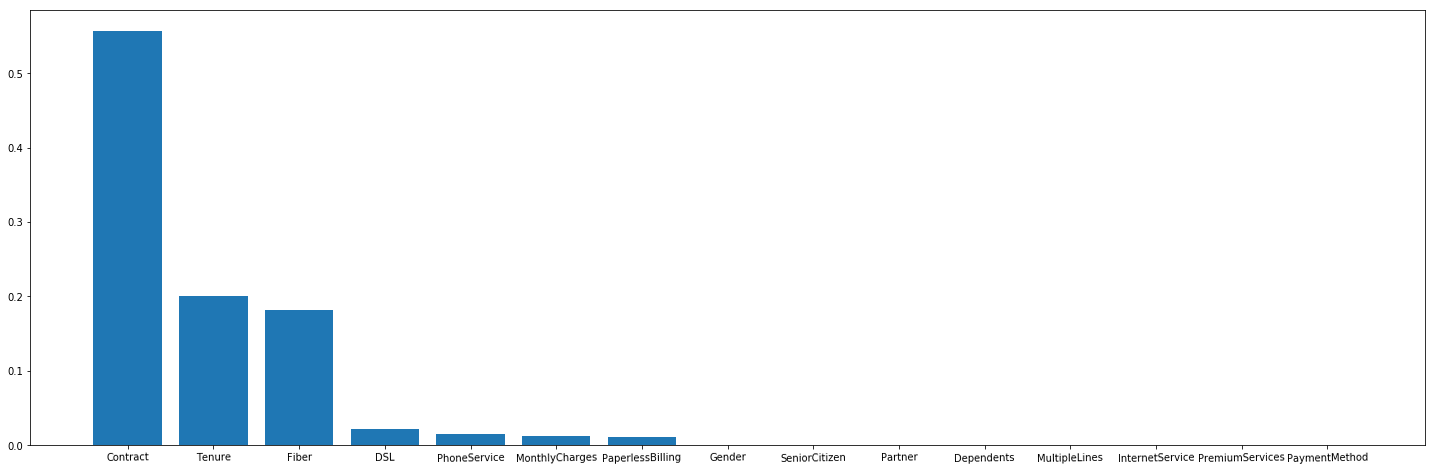

In [ ]:
out_test = get_feature_importance_list(data_biggroup, res_grid[4114][2])
out_test
plt.figure(figsize=(25,8))
plt.bar(*zip(*out_test))
plt.xticks(rotation=1)
plt.show()

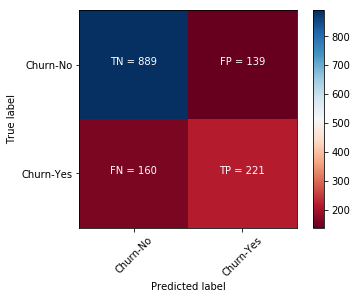

Accuracy: 78.779%
Recall: 58.005% 
Precision: 61.389%
F1: 59.649%
Average precision-recall score: 46.964%


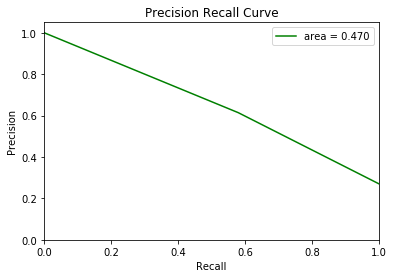

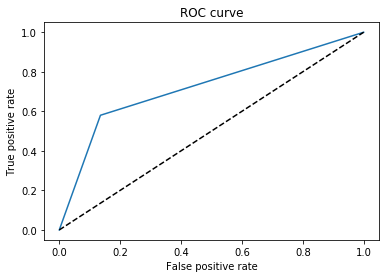

In [ ]:
pred_test = res_grid[4114][2].predict(X_val_b)
plot_everything(res_grid[4114][2], Y_val_b, pred_test)

In [ ]:
scores = cross_val_score(res_grid[4114][2], X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(res_grid[4114][2], X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.7872 (+/- 0.02)
F1-score: 0.7066 (+/- 0.04)


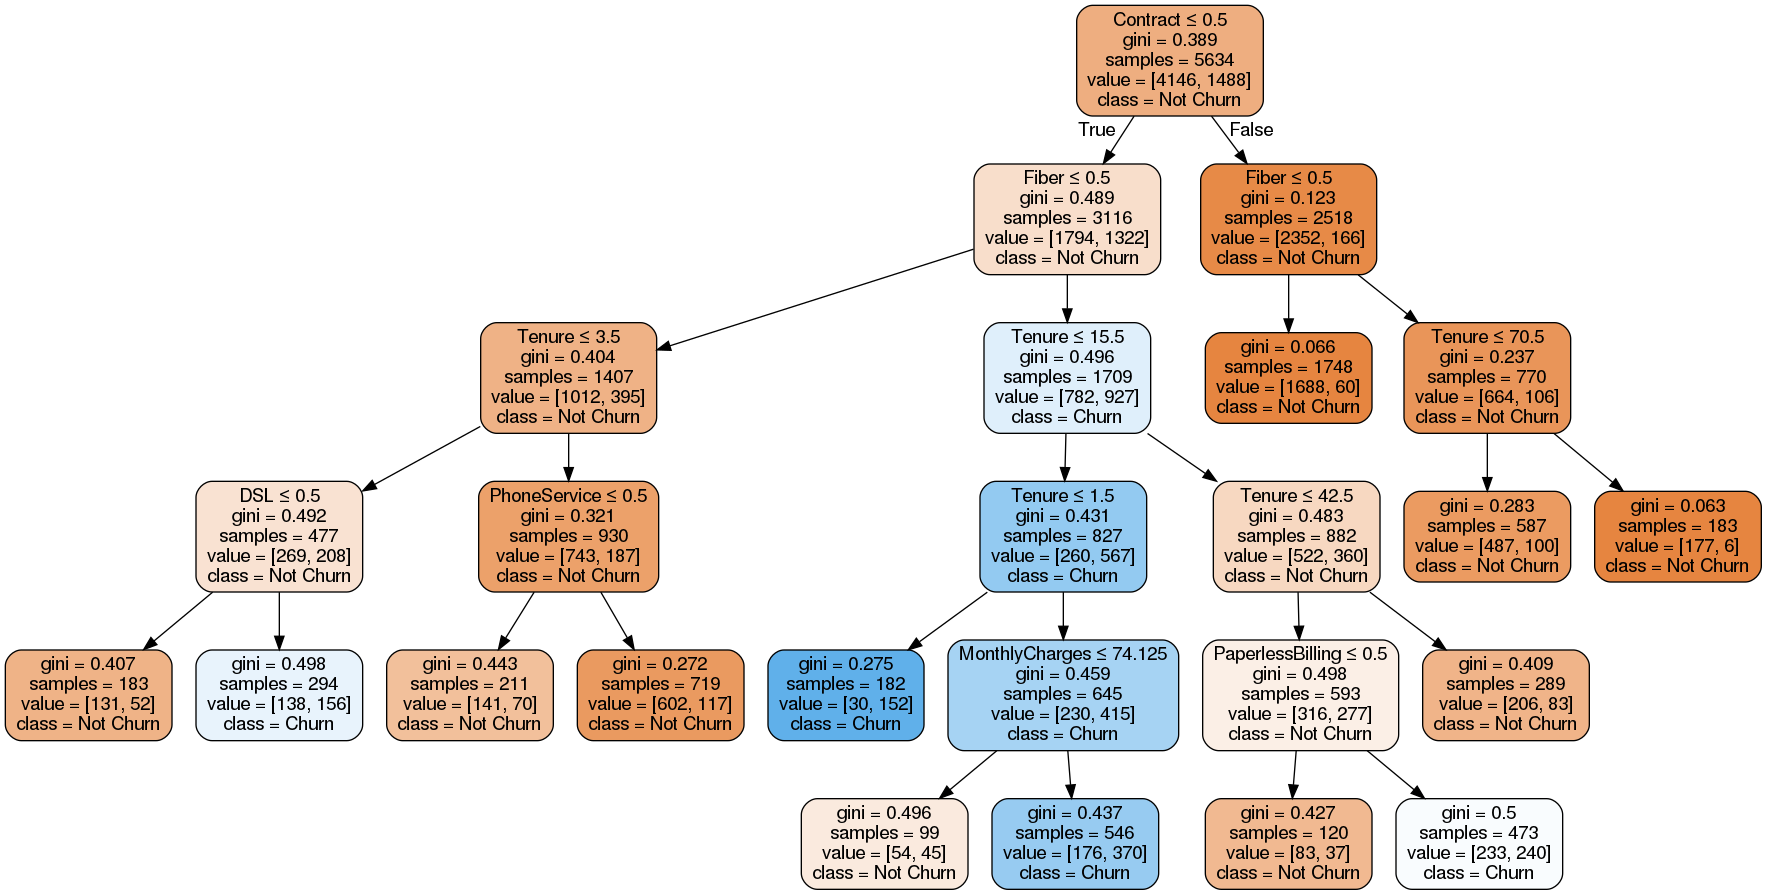

In [ ]:
CHOSEN_CLASSIFIER = res_grid[4114][2]
dot_data = tree.export_graphviz(CHOSEN_CLASSIFIER, out_file=None,
                             feature_names=data_biggroup.columns[:-1],
                             class_names=['Not Churn', 'Churn'],
                             filled=True, rounded=True,
                             special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

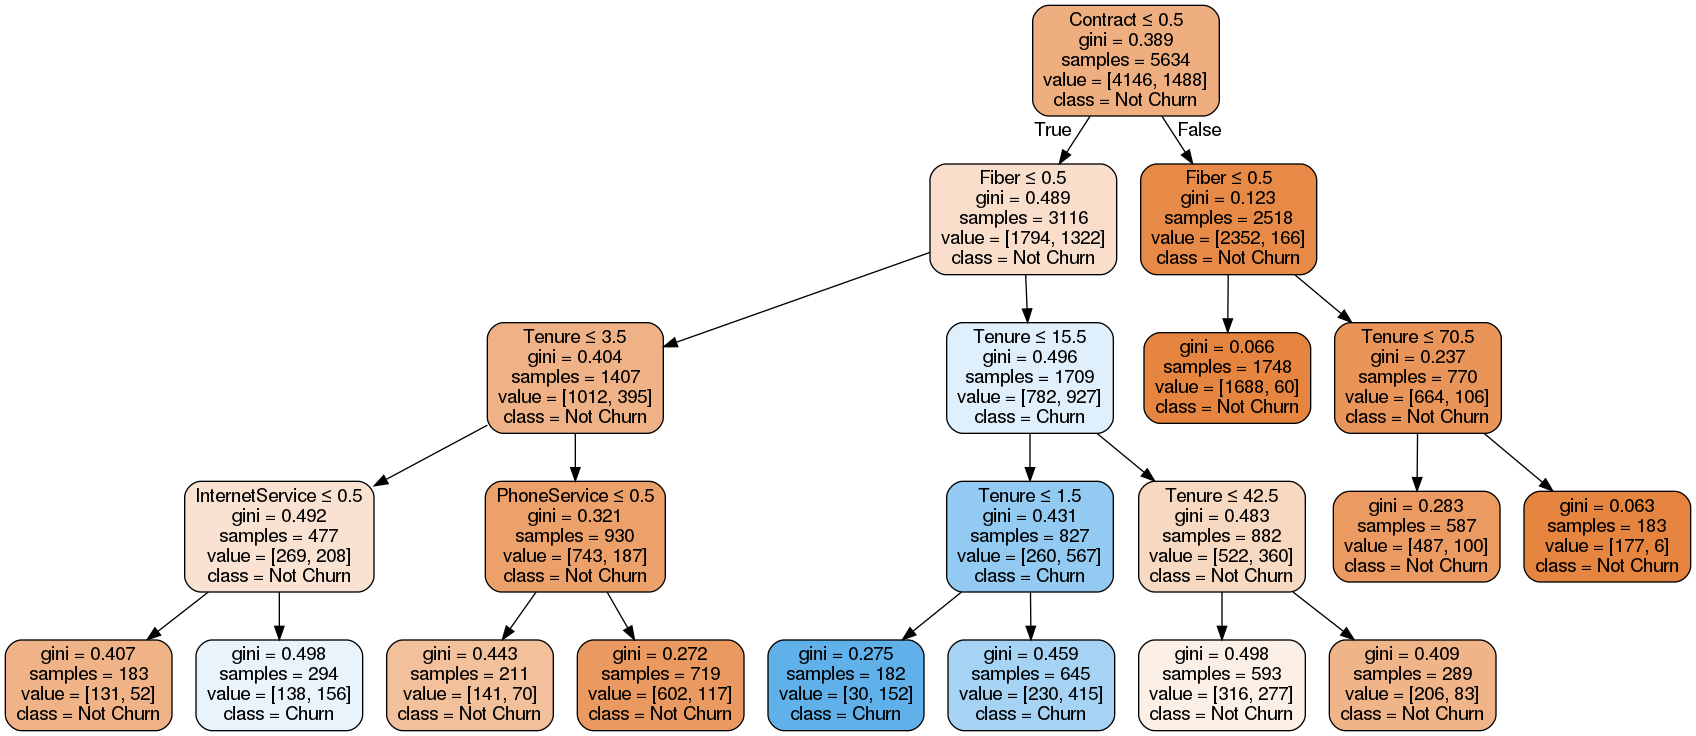

In [ ]:
CHOSEN_CLASSIFIER = res_grid[3062][2]
dot_data = tree.export_graphviz(CHOSEN_CLASSIFIER, out_file=None,
                             feature_names=data_biggroup.columns[:-1],
                             class_names=['Not Churn', 'Churn'],
                             filled=True, rounded=True,
                             special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

/home/lore/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=30, criterion='gini',max_features=None,max_depth=None,
                                min_samples_split=2, min_samples_leaf=5, bootstrap=True, oob_score=False,
                                random_state=None, class_weight=None)
rf_clf.fit(X_train_b, Y_train_b)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
def print_features_score(data, classifier):
    _attr_names = list(data.columns)
    _feat_importance = classifier.feature_importances_
    for i, feature_score in enumerate(_feat_importance):
        print(f'Feature: {_attr_names[i]}\nImportance Score: {_feat_importance[i]}')
        print('#'*50)
        print('\n')

def get_feature_importance_list(data, classifier):
    feat_list = list()
    _attr_names = list(data.columns)
    _feat_importance = classifier.feature_importances_
    for i, feature_score in enumerate(_feat_importance):
        feat_list.append((_attr_names[i], _feat_importance[i]))
    return sorted(feat_list, key=lambda x:x[1], reverse=True)

In [ ]:
feature_score_list = get_feature_importance_list(data_biggroup, rf_clf)

In [ ]:
pred_rf_tr = rf_clf.predict(X_train_b)
r = evalaute(pred_rf_tr, Y_train_b, True)

Accuracy: 88.5952%
Precision: 85.1452%
Recall: 68.8591%
F1-measure: 76.141%


In [ ]:
pred_rf_test = rf_clf.predict(X_val_b)
r2 = evalaute(pred_rf_test, Y_val_b, True)

Accuracy: 80.6794%
Precision: 68.3333%
Recall: 53.5248%
F1-measure: 60.0293%


In [ ]:
from IPython.display import clear_output

def grid_search_rfc(x_training_set, y_training_set, x_test_set, y_test_set, n_estimator, criterion, max_depth,
                    min_samples_split, min_sample_leaf, max_features, min_impurity_decrease, class_weight):
    results = list()
    _param = [n_estimator, criterion, max_depth, min_samples_split, min_sample_leaf, max_features,
              min_impurity_decrease, class_weight]

    total_models = 1
    for elem in _param:
        total_models *= len(elem)
    print(total_models)

    for index, comb in enumerate(itertools.product(*_param)):
        if index%10 == 0:
            print(f'Progress: {index}/{total_models}')
        rf_clf = RandomForestClassifier(n_estimators=comb[0], criterion=comb[1], max_depth=comb[2], min_samples_split=comb[3],
                                        min_samples_leaf=comb[4], max_features=comb[5],
                                        min_impurity_decrease=comb[6], class_weight=comb[7],
                                        bootstrap=True, oob_score=False, random_state=None)

        rf_clf.fit(x_training_set, y_training_set)
        pred_tr = rf_clf.predict(x_training_set)
        score_tr = evalaute(pred_tr, y_training_set)
        pred_test = rf_clf.predict(x_test_set)
        score_test = evalaute(pred_test, y_test_set)
        results.append((score_tr, score_test, rf_clf, comb))
        if index%100 == 0:
            clear_output()
    return results

In [ ]:
n_estimator = [25, 28, 30, 32, 35]
criterion = ['gini', 'entropy']
max_depth = [None]
min_samples_leaf = [2,5,10,20,50,80,100]
min_samples_split = [2,5,10,20,50,80,100]
max_features = ['sqrt']
min_impurity_decrease = [0, 1*math.exp(-6),5*math.exp(-6)]
class_weights = [None]

res_grid_rfc = grid_search_rfc(X_train_b,Y_train_b, X_val_b, Y_val_b,
                               n_estimator, criterion, max_depth,
                               min_samples_split, min_samples_leaf, max_features,
                               min_impurity_decrease, class_weights)

Progress: 1410/1470
Progress: 1420/1470
Progress: 1430/1470
Progress: 1440/1470
Progress: 1450/1470
Progress: 1460/1470


In [ ]:
explore_grid(res_grid_rfc)

Max ACCURACY on training: 0.9101 - model at index 441
with hparam: (28, 'entropy', None, 2, 2, 'sqrt', 0, None)
Max ACCURACY on validation: 0.8011 - model at index 1260
with hparam: (35, 'gini', None, 50, 2, 'sqrt', 0, None)

Max F1-SCORE on training: 0.8146 - model at index 441
with hparam: (28, 'entropy', None, 2, 2, 'sqrt', 0, None)
Max F1-SCORE on validation: 0.5773 - model at index 1218
with hparam: (35, 'gini', None, 10, 2, 'sqrt', 0, None)



In [ ]:
res_grid_rfc[1218]

([0.8685704150407946,
  0.8192668371696504,
  0.6449664429530201,
  0.721742395794217],
 [0.7968860580325549,
  0.6621621621621622,
  0.5117493472584856,
  0.577319587628866],
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 (35, 'gini', None, 10, 2, 'sqrt', 0, None))

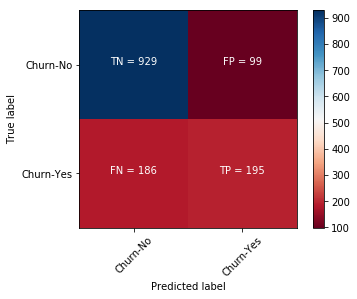

Accuracy: 79.77300000000001%
Recall: 51.181% 
Precision: 66.327%
F1: 57.778%
Average precision-recall score: 47.148%


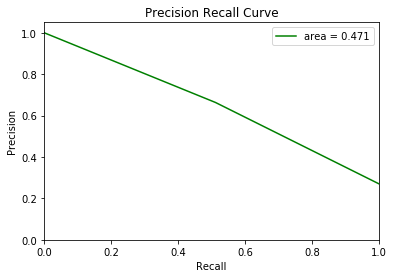

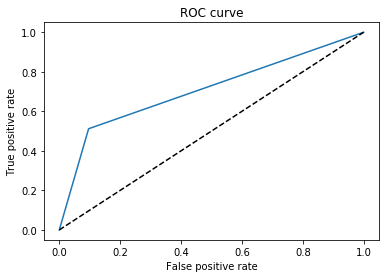

In [ ]:
pred_test = res_grid_rfc[1218][2].predict(X_val_b)
plot_everything(res_grid_rfc[1218][2], Y_val_b, pred_test)

In [ ]:
out_test = get_feature_importance_list(data_biggroup, res_grid_rfc[1218][2])
out_test

[('Tenure', 0.2865179784053195),
 ('MonthlyCharges', 0.2206864234499619),
 ('Contract', 0.15880543886439827),
 ('Fiber', 0.07780297445405204),
 ('PaymentMethod', 0.04593935439257505),
 ('PaperlessBilling', 0.035386234157764485),
 ('InternetService', 0.024585050330063408),
 ('Dependents', 0.0236739161359081),
 ('SeniorCitizen', 0.02292167740480811),
 ('Gender', 0.022044979482524363),
 ('Partner', 0.021571140455205983),
 ('MultipleLines', 0.019716529624339126),
 ('DSL', 0.01677748410967759),
 ('PremiumServices', 0.014442938198520555),
 ('PhoneService', 0.009127880534881562)]

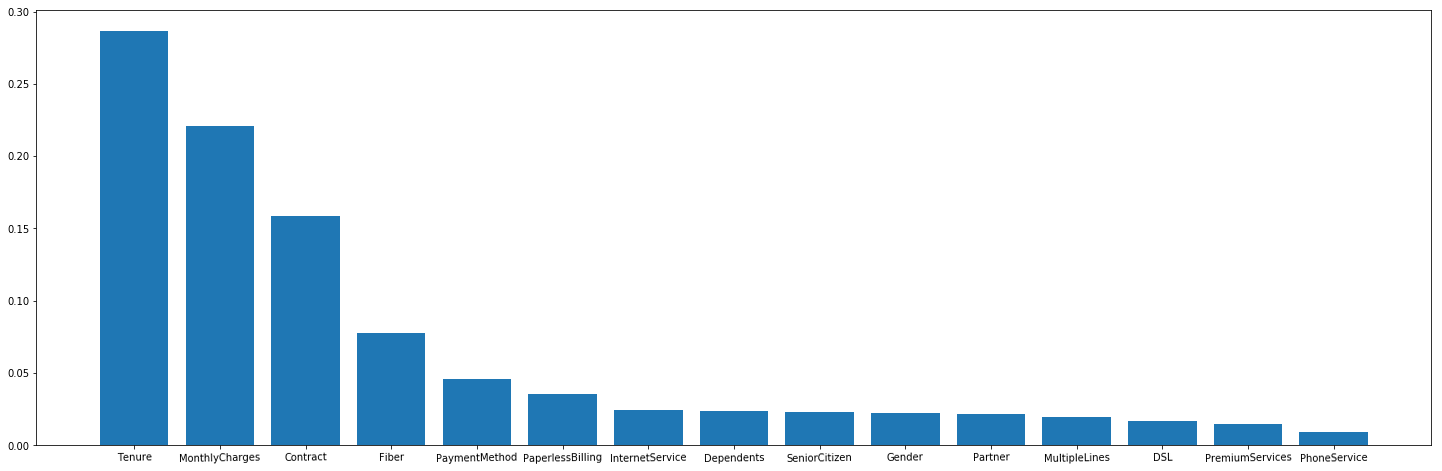

In [ ]:
out_test = get_feature_importance_list(data_biggroup, res_grid_rfc[1218][2])
out_test
plt.figure(figsize=(25,8))
plt.bar(*zip(*out_test))
plt.xticks(rotation=1)
plt.show()

# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adaBoost = AdaBoostClassifier(n_estimators=150, learning_rate=1)
adaBoost.fit(X_train_b, Y_train_b)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=150, random_state=None)

In [ ]:
pred_ada_tr = adaBoost.predict(X_train_b)
ada_eval_tr = evalaute(pred_ada_tr, Y_train_b, True)
print('\n')
pred_ada_test = adaBoost.predict(X_val_b)
ada_eval_test = evalaute(pred_ada_test, Y_val_b, True)

Accuracy: 80.6846%
Precision: 66.1824%
Recall: 55.0336%
F1-measure: 60.0953%


Accuracy: 79.4763%
Precision: 65.1466%
Recall: 52.2193%
F1-measure: 57.971%


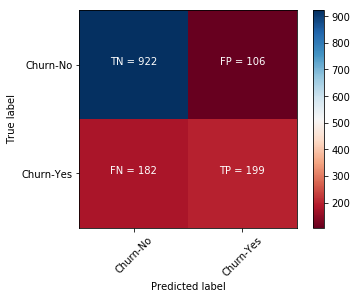

Accuracy: 79.56%
Recall: 52.231% 
Precision: 65.246%
F1: 58.017%
Average precision-recall score: 46.996%


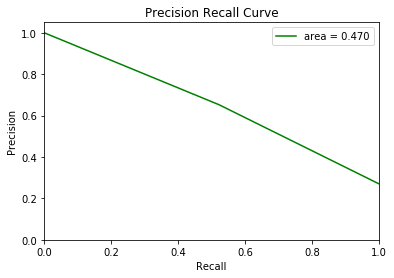

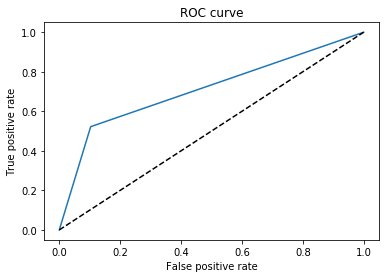

In [ ]:
plot_everything(adaBoost, Y_val_b, pred_ada_test)